/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<AxesSubplot:title={'center':'70 years performance data of major asset classes'}, xlabel='year', ylabel='index points'>

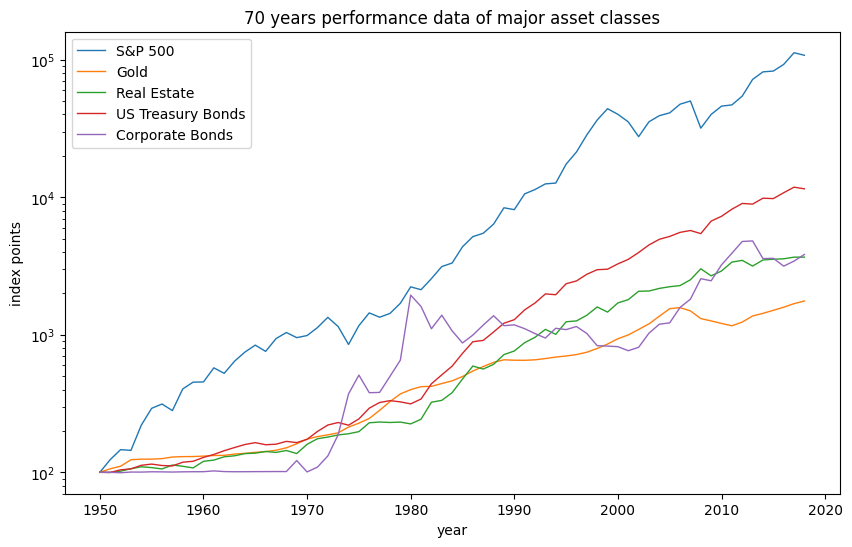

In [2]:
# to run code type:
# pyenv shell 3.9.1
# pipenv shell

import pandas as pd

raw_data = pd.read_csv('data.csv')
columns_selection = ["Year", "S&P 500 (includes dividends)", 'US T. Bond', 'Real Estate','Inflation Rate', "Baa Corporate Bond"]
ts_selection = ["Year", "S&P 500 (includes dividends)3",'Real Estate2', 'US T. Bond5', "Baa Corporate Bond6" ]
raw = raw_data[ts_selection]

# prepare data for plotting
for c in ts_selection[1:]:
    raw[c] = raw[c].apply(lambda x: float(x[1:].replace(",","")))
raw = raw[[int(year) < 2019 and int(year) > 1949 for year in raw["Year"]]]


# prepare training data
data = raw_data[columns_selection]
for c in columns_selection[1:]:
    data[c] = data[c].apply(lambda x: float(x[:-1])/100 + 1)
data = data[[int(year) < 2019 and int(year) > 1949 for year in data["Year"]]]


gold = pd.read_csv("monthly.csv")
is_january = [x[-2:] == "01" for x in gold["Date"].values]

# is_january = gold[[date[:-2:] == "01" for date in gold["Date"].values]]
# gold = gold[is_january]
#gold
gold = gold[is_january]
data["gold"] = gold["Price"].values

data["gold"] = data["gold"].pct_change()
data["gold"] = data["gold"].apply(lambda x: x + 1)

#prepare plotting data
ts_selection.append("gold")
raw["gold"] = gold["Price"].values
for c in ts_selection[1:]:
    raw[c] = 100 / raw[c].values[0] * raw[c] 

raw_renamed = raw.copy()
raw_renamed.columns = ["Year","S&P 500", "Gold",'Real Estate', 'US Treasury Bonds', "Corporate Bonds" ]
raw_renamed.plot("Year", ["S&P 500", "Gold",'Real Estate', 'US Treasury Bonds', "Corporate Bonds" ], linewidth=1.0, figsize= (10,6), logy=True, xlabel="year", ylabel="index points",  title="70 years performance data of major asset classes")

#print(gold.head(3))
#print(data.head(10)
#data.columns

<AxesSubplot:title={'center':'70 years performance data of major asset classes'}, xlabel='year', ylabel='index points'>

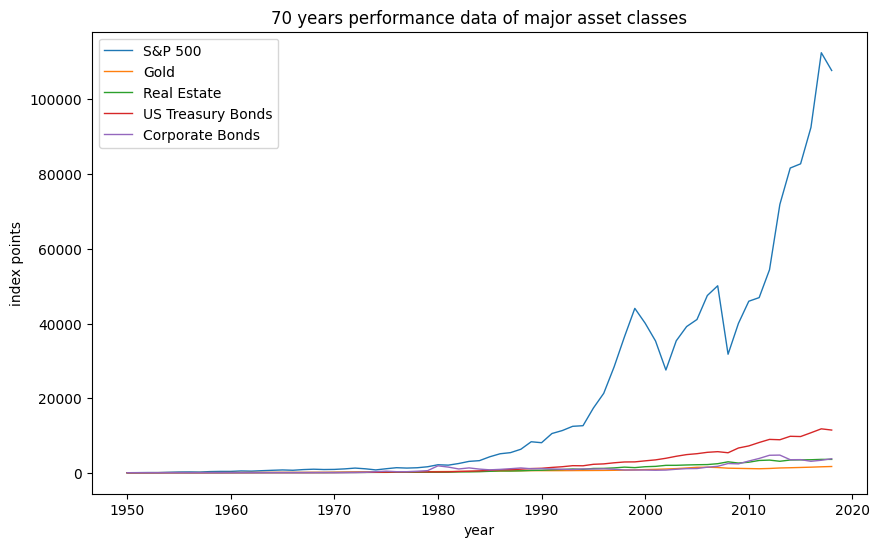

In [3]:
raw_renamed.plot("Year", ["S&P 500", "Gold",'Real Estate', 'US Treasury Bonds', "Corporate Bonds" ], linewidth=1.0, figsize= (10,6), xlabel="year", ylabel="index points", title="70 years performance data of major asset classes")


In [5]:
import gym
from gym import spaces
import numpy as np
import math

def get_random_integer_between(a,b,c=0):
  np.random.seed(c)
  no = (min(max(np.random.normal(0,1), -4),4)/4) * ((b-a)/2) + a + (b-a)/2
  no = int(round(no,0))
  return no

class CustomEnv(gym.Env):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}
    def __init__(self, data, rebalancing=False):
        super(CustomEnv, self).__init__()
        self.data = data
        self.rebalancing = rebalancing
        self.current_step = 0
        self.horizon_preference = 5
        self.risk_preference = 50
        self.current_point_in_time = 11
        self.reward_range = (-np.inf, np.inf) 
        # Define action and observation space
        # They must be gym.spaces objects
        # Space of possible actions:
        self.action_space = spaces.Box(low=0.001, high=1, shape=(4,))
        if rebalancing == "learn":
          self.action_space = spaces.Box(low=0.001, high=1, shape=(5,))
       

        # Example for using image as input (channel-first; channel-last also works):

        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(58, ), dtype=np.float16)
    
    def get_obs_sample(self):
        return self.observation_space.sample()

    def get_random_preferences(self):
      return np.array([get_random_integer_between(0,10), get_random_integer_between(0,100)],dtype=np.float32)

    def set_current_observation(self, observation):
      self.current_observation = observation

    def get_current_observation(self, current_point_in_time=False, risk_preference=False, horizon_preference=False):
      self.current_point_in_time = current_point_in_time if current_point_in_time else get_random_integer_between(11,57, self.current_step)#np.random.randint(11,57)
      self.risk_preference = risk_preference if risk_preference else get_random_integer_between(0,100, self.current_step)#np.random.randint(0,100)   
      self.horizon_preference = horizon_preference if horizon_preference else get_random_integer_between(5,10, self.current_step)#np.random.randint(5,10)
      self.current_asset_data = np.array(self.data[["S&P 500 (includes dividends)", "gold", "Real Estate", "US T. Bond", "Baa Corporate Bond"]].iloc[self.current_point_in_time - 10: self.current_point_in_time].values,dtype=np.float32)
      self.std_devs = []
    
      for c in ["S&P 500 (includes dividends)", "gold", "Real Estate", "US T. Bond", "Baa Corporate Bond"]:
        #print(self.data[[c]].iloc[self.current_point_in_time - 10: self.current_point_in_time].std().values[0])
        self.std_devs.append(self.data[[c]].iloc[self.current_point_in_time - 10: self.current_point_in_time].std().values[0])
      
      self.std_devs = np.array(self.std_devs,dtype=np.float32 )
      #print(self.std_devs)
      self.current_observation =  np.concatenate((
        self.current_asset_data.flatten(),
        np.array([self.risk_preference, self.horizon_preference, self.current_point_in_time],dtype=np.float32),
        self.std_devs),
        axis=None
        )
      #print("current observation {}".format(self.current_observation))
      #print("Step: {}".format(self.current_step))
      #next_observation = self.get_current_observation(current_point_in_time=get_random_integer_between(11,57,self.current_step), risk_preference=get_random_integer_between(0,100,self.current_step), horizon_preference=get_random_integer_between(5,10,self.current_step))

      #print("Observation: {}".format(self.current_observation))
      return self.current_observation


    def reset(self):
      #print("RESET")
      #self.current_step = 0
      #self.action= np.array([50,50],dtype=np.float32)
      return self.get_current_observation()

    
    def _next_observation(self):
      #print(get_random_integer_between(0,100,self.current_step))
      self.current_step += 1
      self.current_point_in_time = get_random_integer_between(11,57,self.current_step)
      self.risk_preference=get_random_integer_between(0,100,self.current_step)
      self.horizon_preference=get_random_integer_between(5,10,self.current_step)

      #print("Step next obs: {}".format(self.current_step))
      #print("Random number based on step: {}".format(get_random_integer_between(5,10,self.current_step)))
      next_observation = self.get_current_observation(current_point_in_time=get_random_integer_between(11,57,self.current_step), risk_preference=get_random_integer_between(0,100,self.current_step), horizon_preference=get_random_integer_between(5,10,self.current_step))

      #print("Observation next obs: {}".format(next_observation))
      #print("Current Step: {}".format(self.current_step))
      return next_observation

    def _calculate_reward(self, action, *args, **kwargs):
      #relevant_timeseries = self.data[["S&P 500 (includes dividends)", "gold", "Real Estate", "US T. Bond", "Baa Corporate Bond"]].iloc[self.current_point_in_time: self.current_point_in_time + self.horizon_preference]
      #print("Action {}".format(action))
      relevant_timeseries = self.data[["S&P 500 (includes dividends)", "gold", "Real Estate", "US T. Bond"]].iloc[self.current_point_in_time: self.current_point_in_time + self.horizon_preference]
      #print("risk pref: {}\n horizon: {}\n relevant_timeseries: {}".format(self.risk_preference, self.horizon_preference, relevant_timeseries))
      reb_action = 0
      if self.rebalancing == "learn":
        reb_action = action[4]
        action = np.array([action[0],action[1],action[2],action[3]])
      action_sum = action.sum()#
      asset_allocation = [action[0]/action_sum, action[1]/action_sum, action[2]/action_sum, action[3]/action_sum]
      
     
       

      if self.rebalancing:
        aggregated_timeseries = []
        i = 0
        for step in relevant_timeseries.iterrows():
          if i == 0:
          # calculate asset allocation after step
            aggregated_timeseries.append(
              asset_allocation[i] * step[1].values
            ) 
            i += 1
          else:
            resulting_allocation = [aggregated_timeseries[-1][i] / np.array(aggregated_timeseries[-1]).sum() for i in [0,1,2,3]]
          
            #print("max drift is {}".format(abs(max(([(resulting_allocation[i] - asset_allocation[i])/asset_allocation[i] for i in [0,1,2,3]]), key=abs))))
            max_deviation = abs(max(([(resulting_allocation[i] - asset_allocation[i])/asset_allocation[i] for i in [0,1,2,3]]), key=abs))
            if (self.rebalancing == "learn" and max_deviation > reb_action) or (self.rebalancing not in [False, "learn"] and max_deviation > self.rebalancing):
              #print("rebalancing necessary!")
              # do rebalacing
              #print("rebalancing... {}\nboundary: {}".format(max_deviation, reb_action))
              current_portfolio_value = np.array(aggregated_timeseries[-1]).sum()
              rebalanced_portfolio = [asset_allocation[i] * current_portfolio_value for i in [0,1,2,3]]
              aggregated_timeseries.append(
                rebalanced_portfolio * (step[1].values)
              ) 
              
            else:
              # let go
              aggregated_timeseries.append(
                aggregated_timeseries[-1] * (step[1].values)
              ) 
              #print("a: {}\nb: {}".format(aggregated_timeseries[-1], step[1].values))
              #print("resulting: {} \n aimed: {}".format(resulting_allocation,asset_allocation))
        aggregated_timeseries_calc = pd.Series([i.sum() for i in aggregated_timeseries]).pct_change().values
          # erstes jahr wird ausgenommen, da kein Zuwachs berechenbar
        increments = np.array([1 + i for i in aggregated_timeseries_calc][1:])
        aggregated_timeseries = increments.cumprod()
              #print("delta in timeseries: {}\n current timeseries: {}".format(step[1].values, aggregated_timeseries[-1]))
        #print("timeseries result  with rebalancing: {}".format(aggregated_timeseries))
        #print("inverse cumprod is {}".format(increments))
        # sum allocations over all asset classes to get a 1 dimensional timeseries: 
        # die aggregated timeseries muss in jedem jahr den wertzuwachs zeigen, z.B. +10% -> 1.1, +20% -> 1.2
         

        
        
        #print("final timeseries with rebalancing; {}".format(aggregated_timeseries))
        #return aggregated_timeseries[-1].sum()
        #aggregated_timeseries = []
      else:

        increments = 1 + (action[0] / action.sum())*(relevant_timeseries["S&P 500 (includes dividends)"].values-1) \
        +((action[1] / action.sum())*(relevant_timeseries["gold"].values-1))
        + ((action[2] / action.sum())*(relevant_timeseries["Real Estate"].values-1)) \
            + ((action[3] / action.sum())*(relevant_timeseries["US T. Bond"].values-1)) 
        
        aggregated_timeseries = 1 + (action[0] / action.sum())*(relevant_timeseries["S&P 500 (includes dividends)"].values.cumprod()-1) \
        +((action[1] / action.sum())*(relevant_timeseries["gold"].values.cumprod()-1)) \
          + ((action[2] / action.sum())*(relevant_timeseries["Real Estate"].values.cumprod()-1)) \
            + ((action[3] / action.sum())*(relevant_timeseries["US T. Bond"].values.cumprod()-1)) 
        # erstes jahr wird ausgenommen, da kein Zuwachs berechenbar
        #print("final timeseries  w/o rebalancing aa: {}".format(aggregated_timeseries))
        aggregated_timeseries = aggregated_timeseries[1:]
        #print("final timeseries  w/o rebalancing: {}".format(aggregated_timeseries))
        #print("increments are {}".format(increments))
        
      # add "fear of missing out"
      unrepresented_assets_penality = 1
      for act in action:
        unrepresented_assets_penality *= 1 - 5.5* (0.05 - min(act, 0.05))
          

      #reward = list(aggregated_timeseries.cumprod())[-1] - self.risk_preference * aggregated_timeseries.std() / 15 #16
      if (self.risk_preference * np.array(aggregated_timeseries).std()) != 0:
        vola_factor = 3 * np.array(increments)[np.where(np.array(increments) < 1)].std()
        if vola_factor == [] or vola_factor == np.nan or math.isnan(vola_factor):
          vola_factor = 0
        #print("negative increments {}".format(np.array(increments)[np.where(np.array(increments) < 1)]))
        reward = list(np.array(aggregated_timeseries))[-1] - ((self.risk_preference) * vola_factor if vola_factor else 1)#/5.25)#/10)
        reward *= unrepresented_assets_penality
        #print("reward attempt is {}".format(reward))
        #reward = max(reward, 0)
      else:
        reward = 0
      if reward == np.nan or math.isinf(reward):
        reward = 0
      else:
        #print(reward)
        return reward

    def calculate_revenue(self, action, *args, **kwargs):
      relevant_timeseries = self.data[["S&P 500 (includes dividends)", "gold", "Real Estate", "US T. Bond", "Baa Corporate Bond"]].iloc[self.current_point_in_time: self.current_point_in_time + self.horizon_preference]
      #print("Action {}".format(action))
     
      aggregated_timeseries = 1 + (action[0] / action.sum())*(relevant_timeseries["S&P 500 (includes dividends)"]-1) \
      +((action[1] / action.sum())*(relevant_timeseries["gold"]-1)) \
         + ((action[2] / action.sum())*(relevant_timeseries["Real Estate"]-1)) \
          + ((action[3] / action.sum())*(relevant_timeseries["US T. Bond"]-1)) 
      
      reward = list(aggregated_timeseries.cumprod())[-1]
      
      if reward == np.nan or math.isinf(reward):
        return 0
      else:
        return reward


    def step(self, action):
      #self._take_action(action)
  
      self.reward = self._calculate_reward(action)
      
      return self._next_observation(), self.reward, self.current_step < 2500, {}

    # def reset(self):
    #     pass
		# #return observation  # reward, done, info can't be included
    def render(self, mode='human'):
      pass
      #print("The reward is {}".format(self.reward))
      #print(self.reward)

    # def close (self):
    #     pass2


# class CustomEnvDisc(CustomEnv):
#   def __init__(self, data):
#         #super(CustomEnvDisc, self).__init__()
#         self.data = data
#         self.reward_range = (-np.inf, np.inf) 
#         self.action_space = spaces.MultiDiscrete(np.array([100,100,100,100]), dtype=int)
#         self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(57, ), dtype=np.float16)
#         #print("action space shape is {}".format(self.action_space.shape))

        

In [6]:
np.array([1,2,3])[np.where(np.array([1,2,3]) < 4)]
math.isnan(np.array([]).std())

/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


True

5.099535833240084


/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.3`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  if __name__ == "__main__":


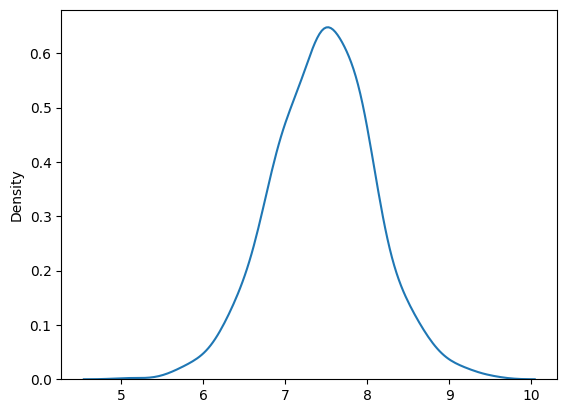

In [7]:
import seaborn as sns
v=[]
a = 5
b = 10
for i in range(0,1000):
    ap = (min(max(np.random.normal(0,1), -4),4)/4) * ((b-a)/2) + a + (b-a)/2
    v.append(ap)

sns.kdeplot(np.array(v), bw=0.3)
print(np.array(v).min())

In [8]:
testEnv  = CustomEnv(data, rebalancing=False)
#get_random_integer_between(0,100)

#print(testEnv._next_observation())
#print(testEnv.get_current_observation())
#print(testEnv.get_current_observation())
#testEnv.step(np.array([1,1,1,1]))


In [9]:
# test environment
testEnvReb = CustomEnv(data, rebalancing=0.12)
testEnvReb1 = CustomEnv(data, rebalancing=0.8)
testEnvReb2 = CustomEnv(data, rebalancing="learn")

testEnvReb.get_current_observation(current_point_in_time=20, risk_preference=50, horizon_preference=20)
testEnvReb2.get_current_observation(current_point_in_time=20, risk_preference=50, horizon_preference=20)
testEnvReb1.get_current_observation(current_point_in_time=20, risk_preference=50, horizon_preference=20)
testEnv.get_current_observation(current_point_in_time=20, risk_preference=50, horizon_preference=20)

rew_reb = testEnvReb._calculate_reward(np.array([1,1,1,1]))
rew_reb1 = testEnvReb1._calculate_reward(np.array([1,1,1,1]))

rew_reb2 = testEnvReb2._calculate_reward(np.array([1,1,1,1, 0.8]))
rew = testEnv._calculate_reward(np.array([1,1,1,1]))
print("reward reb {}\n reward reb1 {} \n reward ohne: {}\nlearn reb: {}".format(rew_reb, rew_reb1, rew, rew_reb2))


reward reb 7.478358553191068
 reward reb1 9.147856976692172 
 reward ohne: 4.427116851522229
learn reb: 9.147856976692172


/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:183: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


In [10]:
import json
import datetime as dt
from stable_baselines.common.policies import MlpPolicy, CnnPolicy, MlpLnLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines import PPO1
from stable_baselines3 import A2C, DDPG, SAC, TD3

#np.array([1,2,3])[-1]

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [11]:
file_name = "validation_set.csv"
test_env = CustomEnv(data)
def create_and_save_val_set(file_name, size=1000):
        data = []
        for i in range(0,1000):
                #obs = test_env.get_current_observation(current_point_in_time=get_random_integer_between(11,57, i), risk_preference=get_random_integer_between(0,100, i), horizon_preference=get_random_integer_between(5,10, i))
                np.random.seed(i)
                obs = [np.random.randint(11,57),get_random_integer_between(0,100, i), get_random_integer_between(5,10, i)]
                data.append(obs)
                #print(get_random_integer_between(25,30, i))
                #print("added to val set: {}".format(obs))
        pd.DataFrame(data).to_csv(file_name)

create_and_save_val_set(file_name)

val_data = pd.read_csv("./"+file_name)
val_data



,Unnamed: 0,0,1,2
0,0,55,72,9
1,1,48,70,9
2,2,51,45,7
3,3,53,72,9
4,4,16,51,8
...,...,...,...,...
995,995,20,42,7
996,996,25,42,7
997,997,17,61,8
998,998,42,51,8


/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.2`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  This is separate from the ipykernel package so we can avoid doing imports until


11

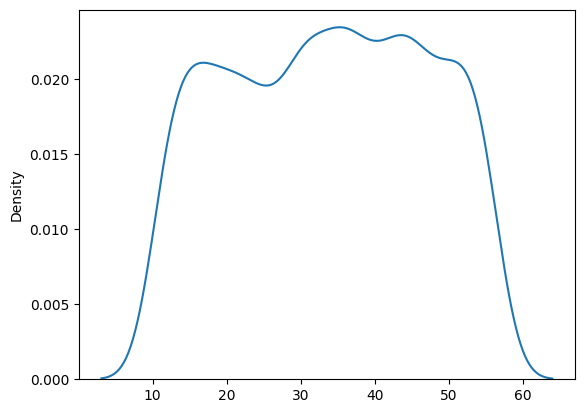

In [12]:
# point in time
val_data["0"].values
sns.kdeplot(np.array(val_data["0"].values), bw=0.2)
val_data["0"].min()

/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.4`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:ylabel='Density'>

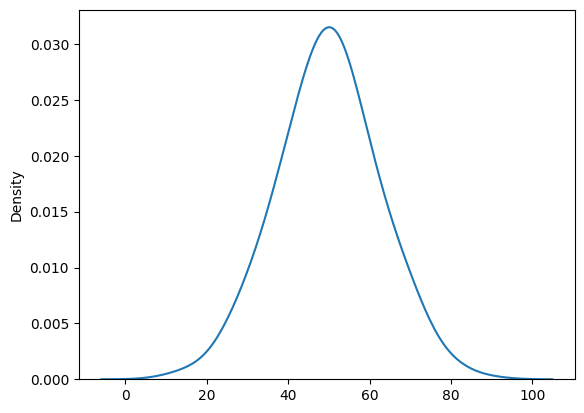

In [13]:
# risk
val_data["1"].values
sns.kdeplot(np.array(val_data["1"].values), bw=0.4)

/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.4`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  """


lower bound: 37.587755125569636
upper bound: 62.412244874430364


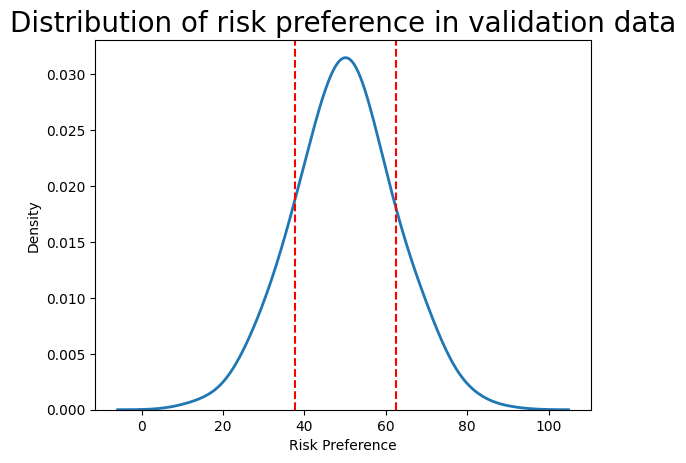

In [14]:
# risk
import matplotlib.pyplot as plt
val_data["1"].values
riskData = pd.DataFrame({"Risk Preference":np.array(val_data["1"].values) })
ax = sns.kdeplot(riskData, x="Risk Preference", bw=0.4, linewidth=2)
ax.set_title("Distribution of risk preference in validation data", fontsize= 20)
#plt.annotate("Hi", xy=(20,10),xytext=(3, 1.5),arrowprops=dict(facecolor='black', shrink=0.05))
lower_risk_bound = 50-val_data["1"].std()
upper_risk_bound = 50+val_data["1"].std()
plt.axvline(x=lower_risk_bound, color='r', label='sigma', ls='--')
plt.axvline(x=upper_risk_bound, color='r', label='sigma', ls='--')
#plt.show()
print("lower bound: {}\nupper bound: {}".format(lower_risk_bound, upper_risk_bound))

/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  import sys


Text(0.5, 1.0, 'Distribution of horizon preference in validation data')

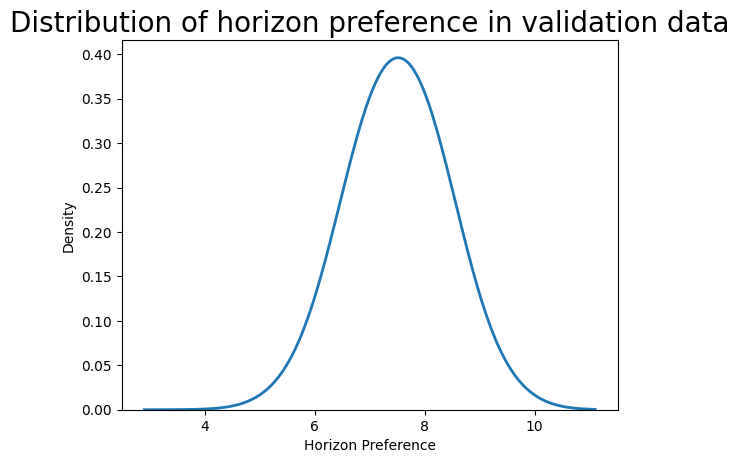

In [16]:
# horizon
# val_data["2"].values
# sns.kdeplot(np.array(val_data["2"].values), bw=1)
# val_data["2"].values.max()

riskData = pd.DataFrame({"Horizon Preference":np.array(val_data["2"].values) })
ax = sns.kdeplot(riskData, x="Horizon Preference", bw=1, linewidth=2)
ax.set_title("Distribution of horizon preference in validation data", fontsize= 20)

In [106]:
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement
from itertools import product

# Training Environment
env = CustomEnv(data)
eval_env = CustomEnv(data)
# Evaluation Callback (should it be on saparate environment? https://stable-baselines3.readthedocs.io/en/master/guide/callbacks.html)
stop_train_callback =  StopTrainingOnNoModelImprovement(max_no_improvement_evals=6, min_evals=5, verbose=0)
eval_callback = EvalCallback(eval_env, eval_freq=80, callback_after_eval=stop_train_callback, verbose=0)

# eval_callback = EvalCallback(env, best_model_save_path="./best_models/",
#                              log_path="./best_models/", eval_freq=5000,
#                              deterministic=True, render=False)

env.get_current_observation()
#env = DummyVecEnv([lambda: CustomEnv(data)])

models = {
	"A2C": A2C, 
	"PPO1":PPO1,
	"DDPG":DDPG,
	"SAC":SAC,
	"TD3":TD3,

	}



#obs = env.get_current_observation()

def calculate_score_on_val(model, rebalancing=False):
	# obs = env.reset()
	# done = False
	# while not done:
	# 	action, _states = model.predict(obs)
	# 	obs, rewards, done, info = env.step(action)
	# 	env.render()
	env = CustomEnv(data, rebalancing=rebalancing)
	actions = []
	for i in val_data.iterrows():
		row = i[1].values[1:]
		env.current_point_in_time = row[0]
		env.risk_preference = row[1]
		env.horizon_preference=row[2]
		action = model.predict(env.get_current_observation(row[0],row[1],row[2]), deterministic=True)
		#print("action is: {}, observation is {}".format(action,i[1].values[1:] ))
		actions.append(action[0])
		try:
			score += env._calculate_reward(action[0])
			revenue += env.calculate_revenue(action[0])
			
			
		except Exception as e:
			print(e)
			score = 0
			revenue = 0
	#print(actions)
	average_action = np.array(actions).mean(axis=0)
	return score, average_action, revenue, actions



models_1={}

In [107]:
scores = {}
average_actions = {}
revenues = {}
actions = {}

total_score = 0
#models = [A2C, PPO, DDPG, SAC, TD3]
learning_rates = [0.01, 0.0001, 0.00001]
batch_sizes = [1,2,3,5]
total_timesteps = 1300

for model, learning_rate, batch_size in product(models, learning_rates, batch_sizes):
	if model == "A2C":
		print(model)
		for use_rms_prop in [True, False]:
			m = models[model]('MlpPolicy',env,learning_rate = learning_rate, n_steps=batch_size, use_rms_prop = use_rms_prop, seed=1)
			m.learn(total_timesteps=total_timesteps, callback=eval_callback)
			key = "{}_{}_{}_{}".format(model,str(learning_rate), str(use_rms_prop), str(batch_size))
			scores[key], average_actions[key], revenues[key], actions[key] = calculate_score_on_val(m)
			models_1[key] = m

	# if model == "TD3":
	# 	print(model)
	# 	m = models[model]('MlpPolicy',env, learning_starts=0, learning_rate=learning_rate, batch_size=batch_size, seed=1)
	# 	m.learn(total_timesteps=total_timesteps, callback=eval_callback)
	# 	key = "{}_{}_-_{}".format(model,str(learning_rate), str(batch_size))
	# 	scores[key], average_actions[key], revenues[key], actions[key] = calculate_score_on_val(m)
	# 	models_1[key] = m

	
	if model == "PPO1":
		print(model)
		m = models[model]('MlpPolicy',env,optim_stepsize=learning_rate, optim_batchsize=batch_size, seed=1)
		m.learn(total_timesteps=total_timesteps, callback=None)#eval_callback)
		key = "{}_{}_-_{}".format(model,str(learning_rate), str(batch_size))
		scores[key], average_actions[key], revenues[key], actions[key] = calculate_score_on_val(m)
		models_1[key] = m

	print("{} score is {}".format(key if key else "", scores[key] if key else ""))

for model in ["SAC"]:#"DDPG", 
	for learning_rate in learning_rates:
		for batch_size in batch_sizes:
			print(model)
			n_actions = env.action_space.shape[-1]
			action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
			m = models[model]('MlpPolicy',env, action_noise=action_noise, learning_starts=0, learning_rate=learning_rate, batch_size=batch_size, seed=1)
			m.learn(total_timesteps=total_timesteps, callback=eval_callback)
			key = "{}_{}_-_{}".format(model,str(learning_rate), str(batch_size))
			scores[key], average_actions[key], revenues[key], actions[key] = calculate_score_on_val(m)
			print("{} score is {}".format(key, scores[key]))
			models_1[key] = m


A2C


/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:183: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/stable_baselines3/c

local variable 'score' referenced before assignment
local variable 'score' referenced before assignment
A2C_0.01_False_1 score is 705.4313116759624
A2C
local variable 'score' referenced before assignment
local variable 'score' referenced before assignment
A2C_0.01_False_2 score is 707.5139461898925
A2C
local variable 'score' referenced before assignment
local variable 'score' referenced before assignment
A2C_0.01_False_3 score is 562.9133698262219
A2C
local variable 'score' referenced before assignment
local variable 'score' referenced before assignment
A2C_0.01_False_5 score is 2.503335634100832
A2C
local variable 'score' referenced before assignment
local variable 'score' referenced before assignment
A2C_0.0001_False_1 score is 281.65707354291527
A2C
local variable 'score' referenced before assignment
local variable 'score' referenced before assignment
A2C_0.0001_False_2 score is 469.8384968286195
A2C
local variable 'score' referenced before assignment
local variable 'score' referenc

In [108]:

benchmark_aggresive = ([(.65 + .75 + .100 + .80)/4,(0.05+0.05+0+0)/4, (.3+.2+.0+.2)/4])
np.array(benchmark_aggresive).sum()
benchmark_aggresive = [i/np.array(benchmark_aggresive).sum() for i in benchmark_aggresive]
benchmark_aggresive = [0.7419354838709677*0.96, 0.03225806451612904*0.96,0.04, 0.22580645161290325*0.96]
np.array(benchmark_aggresive).sum()
benchmark_aggresive

[0.712258064516129, 0.030967741935483874, 0.04, 0.21677419354838712]

In [109]:
benchmark_conservative = ([(.2 + .45 + .2 + .4)/4,(0.5+0.2+0.5+0.2)/4, (.3+.35+.3+.4)/4])
np.array(benchmark_conservative).sum()
benchmark_conservative = [i/np.array(benchmark_conservative).sum() for i in benchmark_conservative]
benchmark_conservative = [0.3125*0.96, 0.35*0.96, 0.04, 0.3375*0.96]
np.array(benchmark_conservative).sum()
benchmark_conservative

[0.3, 0.33599999999999997, 0.04, 0.324]

Text(0.5, 1.0, 'Averaged moderate risk asset allocation')

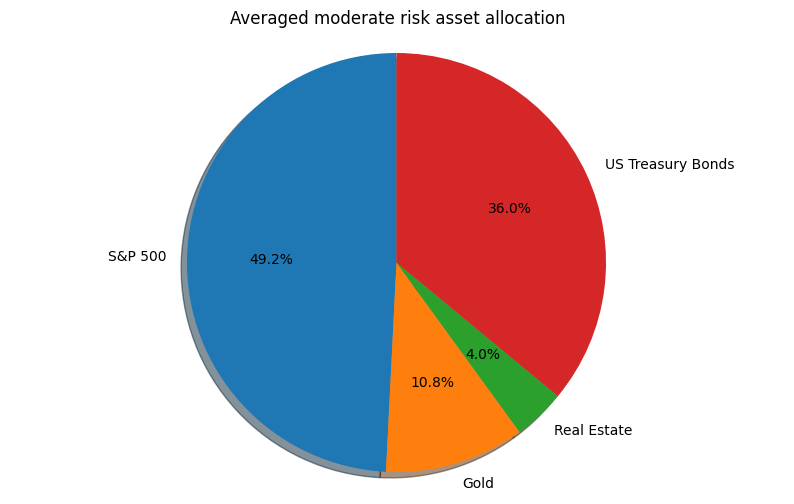

In [110]:
# 11.25 in cash -> gold
# 37.5 in bonds
# 51.25 in stocks
# deduced proportionally for 4 % real estate:
# 10.8 cash, 36 % bonds, 49.2 % stocks -> 4 % real estate

benchmark = np.array([0.492, 0.108, 0.04, 0.36])


import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots(figsize=(10,6))

ax1.pie(benchmark, labels=["S&P 500", "Gold",'Real Estate', 'US Treasury Bonds'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
ax1.set_title("Averaged moderate risk asset allocation")

		#scores["Benchmark"] += env._calculate_reward(benchmark)
		#print("Benchmark Score is {}".format(scores["Benchmark"]))
#print(scores)
#print(average_actions)
#scores

Text(0.5, 1.0, 'Averaged low risk asset allocation')

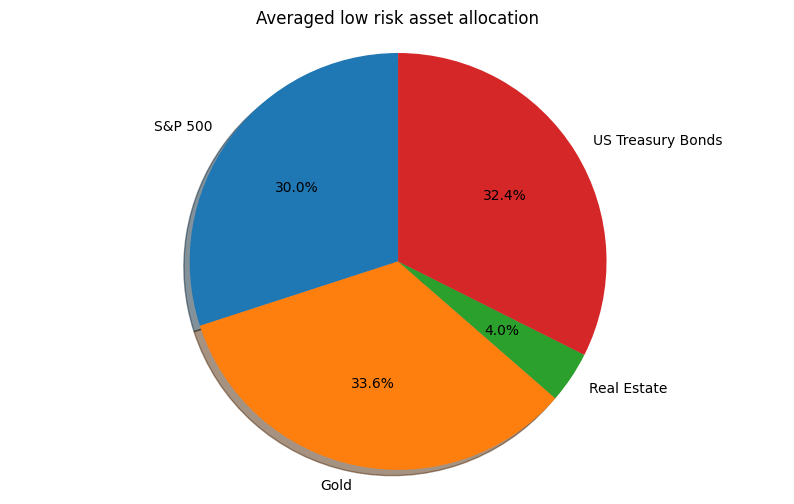

In [111]:
# 11.25 in cash -> gold
# 37.5 in bonds
# 51.25 in stocks
# deduced proportionally for 4 % real estate:
# 10.8 cash, 36 % bonds, 49.2 % stocks -> 4 % real estate

benchmark = np.array([0.492, 0.108, 0.04, 0.36])


import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots(figsize=(10,6))

ax1.pie(benchmark_conservative, labels=["S&P 500", "Gold",'Real Estate', 'US Treasury Bonds'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
ax1.set_title("Averaged low risk asset allocation")

		#scores["Benchmark"] += env._calculate_reward(benchmark)
		#print("Benchmark Score is {}".format(scores["Benchmark"]))
#print(scores)
#print(average_actions)
#scores

Text(0.5, 1.0, 'Averaged high risk asset allocation')

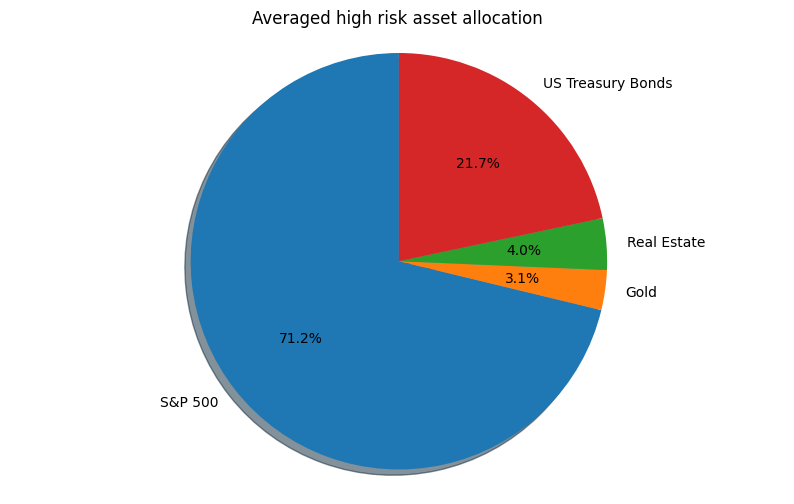

In [112]:
# 11.25 in cash -> gold
# 37.5 in bonds
# 51.25 in stocks
# deduced proportionally for 4 % real estate:
# 10.8 cash, 36 % bonds, 49.2 % stocks -> 4 % real estate

benchmark = np.array([0.492, 0.108, 0.04, 0.36])


import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots(figsize=(10,6))

ax1.pie(benchmark_aggresive, labels=["S&P 500", "Gold",'Real Estate', 'US Treasury Bonds'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
ax1.set_title("Averaged high risk asset allocation")

		#scores["Benchmark"] += env._calculate_reward(benchmark)
		#print("Benchmark Score is {}".format(scores["Benchmark"]))
#print(scores)
#print(average_actions)
#scores

In [113]:
scores["Benchmark"] = 0
revenues["Benchmark"] = 0

for i in val_data.iterrows():
		env.set_current_observation = i[1].values
		try:
			#print(env.current_observation)
			#print(i[1].values)
			env.current_point_in_time = i[1].values[1]
			env.risk_preference=i[1].values[2]
			env.horizon_preference=i[1].values[3]
			#print("risk value is: {}".format(i[1].values[2]))
			if i[1].values[2] <= lower_risk_bound:
				#print("lower")
				scores["Benchmark"] += env._calculate_reward(np.array(benchmark_conservative))
			elif i[1].values[2] >= upper_risk_bound:
				scores["Benchmark"] += env._calculate_reward(np.array(benchmark_aggresive))
				#print("reward is: {}".format(env._calculate_reward(benchmark_aggresive)))
				#print("upper")
			else:
				scores["Benchmark"] += env._calculate_reward(benchmark)
				#print("medium")
			#revenues["Benchmark"] += env.calculate_revenue(benchmark)
		except:
			scores["Benchmark"] = 0
			revenues["Benchmark"] = 0

print("Benchmark score is {}".format(scores["Benchmark"]))

/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:183: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


Benchmark score is 161.48745323524201


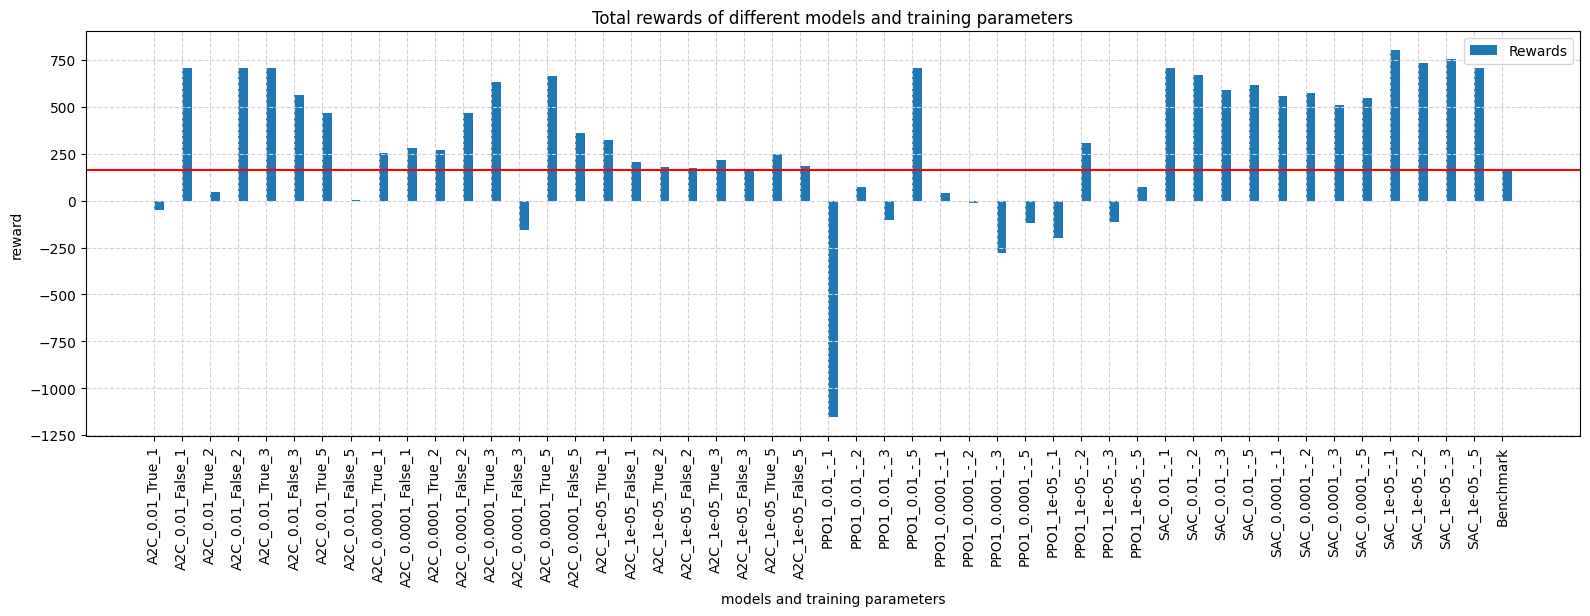

In [114]:



plt.rcParams["figure.figsize"] = (16,5)
fig1, ax1 = plt.subplots()
labels = [k for k in scores]
x = np.arange(len(labels))
#b1 = ax1.bar(x - 0.175 , [revenues[k] for k in revenues], 0.35, label="Revenues")
b2 = ax1.bar(x + 0.175, [scores[k] for k in scores], 0.35, label="Rewards")
ax1.set_xticks(x, labels)
ax1.set_title("Total rewards of different models and training parameters")
# ax1.bar_label(b1, padding=3)
# ax1.bar_label(b2, padding=3)
ax1.set_ylabel("reward")
ax1.set_xlabel("models and training parameters")
fig1.tight_layout()
plt.xticks(rotation='vertical')
plt.axhline(y=scores["Benchmark"], color='r', linestyle='-')
plt.legend()
plt.rc('grid', linestyle="--", color='lightgrey')
plt.grid()
plt.savefig('f_rough_search.pdf', bbox_inches='tight' )
plt.show()


In [115]:

vals = [scores[s] for s in scores.keys()]
sorted(zip(vals, scores.keys()), reverse=True)
#scores["Benchmark"]

[(804.4465418376416, 'SAC_1e-05_-_1'),
 (752.9841233893269, 'SAC_1e-05_-_3'),
 (736.2726542585046, 'SAC_1e-05_-_2'),
 (708.593775027208, 'SAC_1e-05_-_5'),
 (707.5139461898925, 'PPO1_0.01_-_5'),
 (707.5139461898925, 'A2C_0.01_True_3'),
 (707.5139461898925, 'A2C_0.01_False_2'),
 (705.4313116759624, 'SAC_0.01_-_1'),
 (705.4313116759624, 'A2C_0.01_False_1'),
 (670.89442772412, 'SAC_0.01_-_2'),
 (662.6643976248033, 'A2C_0.0001_True_5'),
 (631.8574634476324, 'A2C_0.0001_True_3'),
 (614.4041307031832, 'SAC_0.01_-_5'),
 (591.0416647830998, 'SAC_0.01_-_3'),
 (573.282812745394, 'SAC_0.0001_-_2'),
 (562.9133698262219, 'A2C_0.01_False_3'),
 (557.380230844998, 'SAC_0.0001_-_1'),
 (547.567583648074, 'SAC_0.0001_-_5'),
 (512.4247787793628, 'SAC_0.0001_-_3'),
 (469.8384968286195, 'A2C_0.0001_False_2'),
 (469.79996282437247, 'A2C_0.01_True_5'),
 (359.48980384567295, 'A2C_0.0001_False_5'),
 (323.14046033963535, 'A2C_1e-05_True_1'),
 (305.58919641340924, 'PPO1_1e-05_-_2'),
 (281.65707354291527, 'A2C_0.00

[[0.26025933, 0.07572425, 0.13059013, 0.17288691, 0.1981237, 0.20891055, 0.20955135, 0.20307429, 0.19149818, 0.17653275, 0.15620762, 0.13591242, 0.11815865, 0.103502385, 0.09176091, 0.082389675, 0.07490069, 0.0691716, 0.06557051, 0.06480114, 0.067387134, 0.07302135, 0.08042598, 0.08802595, 0.09475906, 0.10029956, 0.10479777, 0.10856721, 0.111909024, 0.11505065, 0.11813981, 0.121256895, 0.12443183, 0.12766074, 0.13092022, 0.13418013, 0.13741225, 0.14059722, 0.14372776, 0.14680995, 0.14986204, 0.15291233, 0.15599605, 0.15915243, 0.16242151, 0.16584244, 0.16945039, 0.17327549, 0.17734064, 0.18166086, 0.18624192, 0.19108045, 0.19616386, 0.2014717, 0.20697756, 0.212651, 0.2184597, 0.22437148, 0.23035482, 0.23637927, 0.24241467, 0.24842954, 0.25439018, 0.26025933, 0.2659966, 0.2715591, 0.27690384, 0.28198987, 0.28678134, 0.2912496, 0.29537478, 0.29914665, 0.30256382, 0.30563304, 0.3083682, 0.3107879, 0.3129144, 0.31477237, 0.31638753, 0.3177858, 0.31899273, 0.32003248, 0.3209278, 0.32169944,

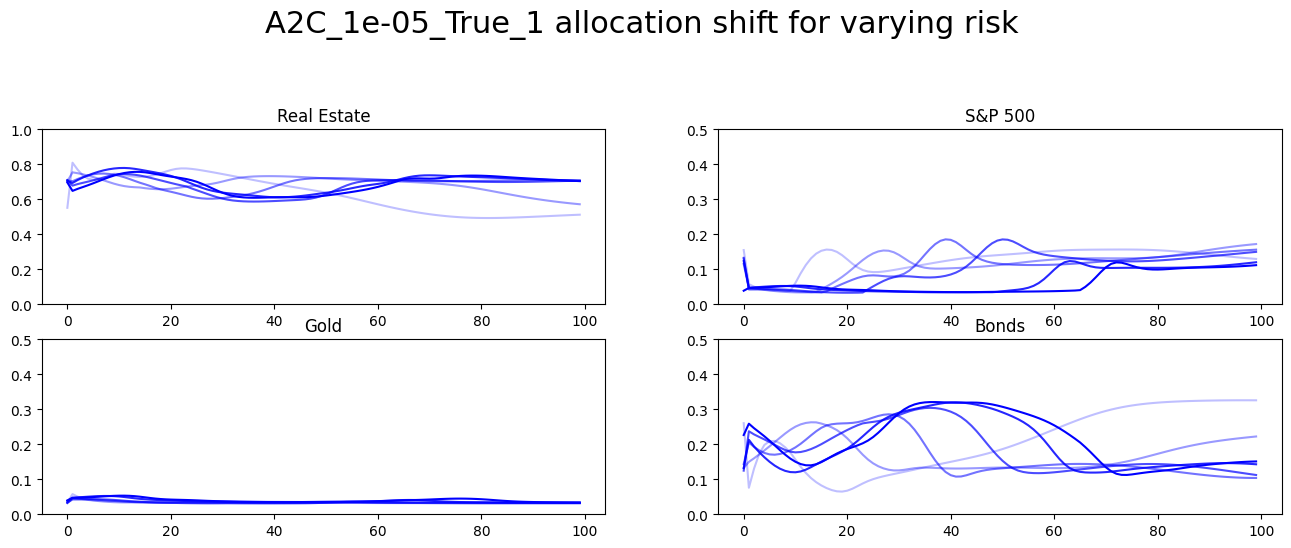

In [121]:
# look at some predictions
 
        # aggregated_timeseries = 1 + (action[0] / action.sum())*(relevant_timeseries["S&P 500 (includes dividends)"].values.cumprod()-1) \
        # +((action[1] / action.sum())*(relevant_timeseries["gold"].values.cumprod()-1)) \
        #   + ((action[2] / action.sum())*(relevant_timeseries["Real Estate"].values.cumprod()-1)) \
        #     + ((action[3] / action.sum())*(relevant_timeseries["US T. Bond"].values.cumprod()-1))
scores_risk = []
risk_actions_sp500 = []
risk_actions_gold = []
risk_actions_real_estate = []
risk_actions_bonds = []
mdls = ['SAC_1e-05_-_1','PPO1_1e-05_-_2','A2C_1e-05_True_1']
mdl=mdls[2]
for pit in [11, 20, 30, 40, 50, 57] :
		#env.set_current_observation = i[1].values
		try:
			#print(env.current_observation)
			#print(i[1].values)
			risk_actions_sp500_inc = []
			risk_actions_gold_inc = []
			risk_actions_real_estate_inc = []
			risk_actions_bonds_inc = []
			for risk_preference in range(0,100):
				env.current_point_in_time = pit
				env.risk_preference=risk_preference
				env.horizon_preference=7
				#action = models_1["PPO1_0.01_-_30"].predict(env.get_current_observation(20,risk_preference, 7), deterministic=True)
				#action = models_1["A2C_0.01_False_10"].predict(env.get_current_observation(20,risk_preference, 7), deterministic=True)
				action = models_1[mdl].predict(env.get_current_observation(env.current_point_in_time,risk_preference, 7), deterministic=True)
				#print("action is: {}, observation is {}".format(action))
				actions_sum = action[0].sum()
				risk_actions_sp500_inc.append(action[0][0]/actions_sum)
				risk_actions_gold_inc.append(action[0][1]/actions_sum)
				risk_actions_real_estate_inc.append(action[0][2]/actions_sum)
				risk_actions_bonds_inc.append(action[0][3]/actions_sum)
				#scores_risk.append(env._calculate_reward(action[0]))
		
			risk_actions_sp500.append(risk_actions_sp500_inc)
			risk_actions_gold.append(risk_actions_gold_inc)
			risk_actions_real_estate.append(risk_actions_real_estate_inc)
			risk_actions_bonds.append(risk_actions_bonds_inc)

		except Exception as e:
			print(e)
			scores_risk.append(0)

print(risk_actions_bonds)
fig = plt.figure()

ax1 = plt.subplot(2, 2, 1)
i = 0
for pit in [11, 20, 30, 40, 50, 57]:
	plt.plot(range(0,100), risk_actions_real_estate[i], color=(0,0,1, 0.25 + i * 0.15 ))
	i += 1
ax1.set_title("Real Estate")
ax1.set_ylim([0, 1])

ax2 = plt.subplot(2, 2, 2)
i = 0
for pit in [11, 20, 30, 40, 50, 57]:
	plt.plot(range(0,100), risk_actions_sp500[i], color=(0,0,1, 0.25 + i * 0.15 ))
	i += 1
ax2.set_title("S&P 500")
ax2.set_ylim([0, .5])

ax3 = plt.subplot(2, 2, 3)
i = 0
for pit in [11, 20, 30, 40, 50, 57]:
	plt.plot(range(0,100), risk_actions_gold[i], color=(0,0,1, 0.25 + i * 0.15 ))
	i += 1
ax3.set_title("Gold")
ax3.set_ylim([0, .5])

ax4 = plt.subplot(2, 2, 4)
i = 0
for pit in [11, 20, 30, 40, 50, 57]:
	plt.plot(range(0,100), risk_actions_bonds[i], color=(0,0,1, 0.25 + i * 0.15 ))
	i += 1
ax4.set_title("Bonds")
ax4.set_ylim([0, .5])

fig.suptitle('{} allocation shift for varying risk'.format(mdl), fontsize=22, y=1.12)
plt.savefig('f_{}_scatter_risk_dep_allocs.pdf'.format(mdl), bbox_inches='tight' )
plt.show()		

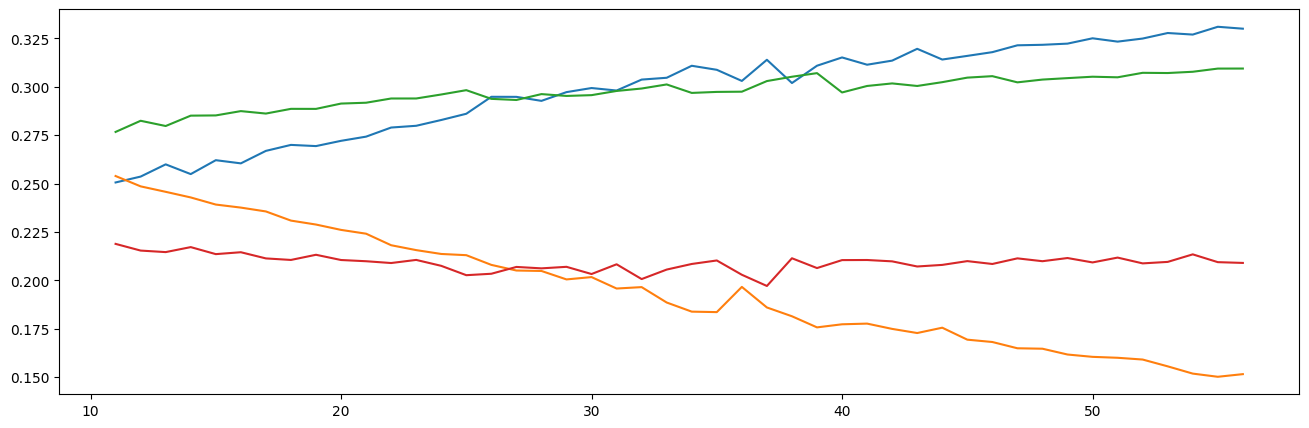

In [118]:

vals = []
for i in [0,1,2,3]:
    over_time_sp500 = []
    for current_point_in_time in range(11,57):
        action = models_1[mdls[0]].predict(env.get_current_observation(current_point_in_time,5, 5), deterministic=True)
        over_time_sp500.append(action[0][i]/action[0].sum())
    vals.append(over_time_sp500)
    #print("action is: {}".format(action))

    plt.plot(range(11,57),over_time_sp500)
    #plt.savefig('f_{}_scatter_risk_dep_allocs.pdf'.format(mdl), bbox_inches='tight' )


In [69]:
# FINE TUNING FOR A2C, SAC, DDPG
# Training Environment
env = CustomEnv(data)
eval_env = CustomEnv(data)
# Evaluation Callback (should it be on saparate environment? https://stable-baselines3.readthedocs.io/en/master/guide/callbacks.html)
stop_train_callback =  StopTrainingOnNoModelImprovement(max_no_improvement_evals=3, min_evals=5, verbose=0)
eval_callback = EvalCallback(eval_env, eval_freq=200, callback_after_eval=stop_train_callback, verbose=0)

# eval_callback = EvalCallback(env, best_model_save_path="./best_models/",
#                              log_path="./best_models/", eval_freq=5000,
#                              deterministic=True, render=False)

env.get_current_observation()
#env = DummyVecEnv([lambda: CustomEnv(data)])

models = {
	#"A2C": A2C, 
	# "PPO1":PPO1,
	#"DDPG":DDPG,
	"SAC":SAC,
	# "TD3":TD3,
	
	}
fine_scores = {}
average_actions = {}
revenues = {}
actions = {}
total_score = 0
learning_rates = [0.01, 0.1, 0.05, 0.3, 0.001]
batch_sizes = [1, 3, 7, 15, 30]
total_timesteps = 1500

for model, learning_rate, batch_size in product(models, learning_rates, batch_sizes):
	if model == "SAC":
		# print(model)
		# m = models[model]('MlpPolicy',env,learning_rate = learning_rate, n_steps=batch_size, use_rms_prop = False, seed=1)
		# m.learn(total_timesteps=total_timesteps, callback=eval_callback)
		# key = "{}_{}_{}".format(model,str(learning_rate), str(batch_size))
		# fine_scores[key], average_actions[key], revenues[key], actions[key] = calculate_score_on_val(m)
		# print("{} score is {}".format(key if key else "", fine_scores[key] if key else ""))
		# models_1[key] = m

		print(model)
		n_actions = env.action_space.shape[-1]
		action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
		m = models[model]('MlpPolicy',env, action_noise=action_noise, learning_starts=0, learning_rate=learning_rate, batch_size=batch_size, seed=1)
		m.learn(total_timesteps=total_timesteps, callback=eval_callback)
		key = "{}_{}_-_{}".format(model,str(learning_rate), str(batch_size))
		fine_scores[key], average_actions[key], revenues[key], actions[key] = calculate_score_on_val(m)
		print("{} score is {}".format(key, fine_scores[key]))
		models_1[key] = m
	# else:
	# 	print(model)
	# 	n_actions = env.action_space.shape[-1]
	# 	action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
	# 	m = models[model]('MlpPolicy',env, action_noise=action_noise, learning_starts=0, learning_rate=learning_rate, batch_size=batch_size, seed=1)
	# 	m.learn(total_timesteps=total_timesteps, callback=eval_callback)
	# 	key = "{}_{}_-_{}".format(model,str(learning_rate), str(batch_size))
	# 	fine_scores[key], average_actions[key], revenues[key], actions[key] = calculate_score_on_val(m)
	# 	print("{} score is {}".format(key, fine_scores[key]))

	
vals = [fine_scores[s] for s in fine_scores.keys()]
print(sorted(zip(vals, fine_scores.keys()), reverse=True))
#scores["Benchmark"]

fine_scores["Benchmark"] = 0
revenues["Benchmark"] = 0

for i in val_data.iterrows():
		env.set_current_observation = i[1].values
		try:
			fine_scores["Benchmark"] += env._calculate_reward(benchmark)
			revenues["Benchmark"] += env.calculate_revenue(benchmark)
		except:
			fine_scores["Benchmark"] = 0
			revenues["Benchmark"] = 0

	

SAC


/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:183: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/stable_baselines3/c

local variable 'score' referenced before assignment
SAC_0.01_-_1 score is 645.8083884760312
SAC
local variable 'score' referenced before assignment
SAC_0.01_-_3 score is 566.6067340921536
SAC
local variable 'score' referenced before assignment
SAC_0.01_-_7 score is 603.2765944832513
SAC
local variable 'score' referenced before assignment
SAC_0.01_-_15 score is 596.8204964387559
SAC
local variable 'score' referenced before assignment
SAC_0.01_-_30 score is 616.1839458312719
SAC
local variable 'score' referenced before assignment
SAC_0.1_-_1 score is 707.5139461898925
SAC
local variable 'score' referenced before assignment
SAC_0.1_-_3 score is 45.36502602288914
SAC
local variable 'score' referenced before assignment
SAC_0.1_-_7 score is 45.36502602288914
SAC
local variable 'score' referenced before assignment
SAC_0.1_-_15 score is 45.36502602288914
SAC
local variable 'score' referenced before assignment
SAC_0.1_-_30 score is -486.10804477728874
SAC
local variable 'score' referenced befor

ValueError: The parameter loc has invalid values

In [635]:
print("############ Scores")
print(sorted(zip(vals, fine_scores.keys()), reverse=True))
#print("############ Revenues")
#print(sorted(zip(revs, revenues.keys()), reverse=True))
#print("############ Actions")
#print(sorted(zip([actions[s] for s in actions.keys()], actions.keys()), reverse=True))
#print(actions)

############ Scores
[(762.6744120608481, 'A2C_0.01_3'), (751.9074784259998, 'A2C_0.1_15'), (749.8234346095848, 'A2C_0.05_15'), (728.3356456935976, 'A2C_0.05_3'), (707.8494731598939, 'A2C_0.01_1'), (554.1106734698403, 'A2C_0.01_15'), (541.5147648524444, 'A2C_0.01_7'), (536.8033576253945, 'A2C_0.05_7'), (509.6095052396029, 'A2C_0.01_30'), (495.05348152968804, 'A2C_0.1_1'), (396.1109412952898, 'A2C_0.3_1'), (381.7510106846181, 'A2C_0.05_30'), (381.727482819788, 'A2C_0.1_30'), (381.70277338772655, 'A2C_0.1_3'), (381.69984963201716, 'A2C_0.3_30'), (375.7927910460977, 'A2C_0.05_1'), (324.04188313402904, 'A2C_0.3_15'), (285.24833189903035, 'A2C_0.3_7'), (285.24833189903035, 'A2C_0.3_3'), (252.75664673761224, 'A2C_0.1_7')]


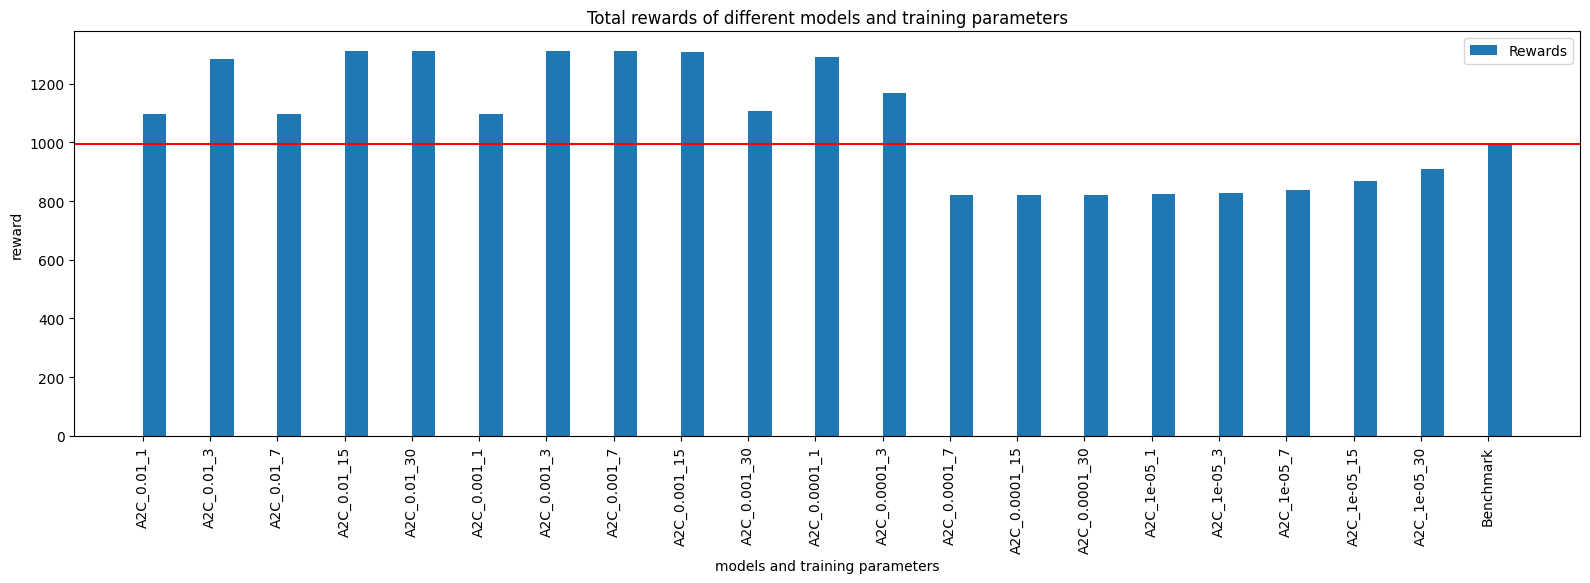

In [21]:



plt.rcParams["figure.figsize"] = (16,5)
fig2, ax1 = plt.subplots()
labels = [k for k in fine_scores]
x = np.arange(len(labels))
#b1 = ax1.bar(x - 0.175 , [revenues[k] for k in revenues], 0.35, label="Revenues")
b3 = ax1.bar(x + 0.175, [fine_scores[k] for k in fine_scores], 0.35, label="Rewards")
ax1.set_xticks(x, labels)
ax1.set_title("Total rewards of different models and training parameters")
# ax1.bar_label(b1, padding=3)
# ax1.bar_label(b2, padding=3)
ax1.set_ylabel("reward")
ax1.set_xlabel("models and training parameters")
fig2.tight_layout()
plt.xticks(rotation='vertical')
plt.axhline(y=scores["Benchmark"], color='r', linestyle='-')
plt.legend()
plt.show()

In [70]:
# REBALANCING ON FINE TUNING RESULTS
# Training Environment
env = CustomEnv(data)
eval_env = CustomEnv(data)
# Evaluation Callback (should it be on saparate environment? https://stable-baselines3.readthedocs.io/en/master/guide/callbacks.html)
stop_train_callback =  StopTrainingOnNoModelImprovement(max_no_improvement_evals=3, min_evals=5, verbose=0)
eval_callback = EvalCallback(eval_env, eval_freq=200, callback_after_eval=stop_train_callback, verbose=0)

# eval_callback = EvalCallback(env, best_model_save_path="./best_models/",
#                              log_path="./best_models/", eval_freq=5000,
#                              deterministic=True, render=False)

#env.get_current_observation()
#env = DummyVecEnv([lambda: CustomEnv(data)])

models = {
	#"A2C": A2C, 
	 #"PPO1":PPO1,
	# "DDPG":DDPG,
	 "SAC":SAC,
	# "TD3":TD3,
	
	}
fine_scores = {}
average_actions = {}
revenues = {}
actions = {}
total_score = 0
learning_rates = [0.01, 0.001]#, 0.0001,0.00001]
batch_sizes = [1, 3, 7]#, 15, 30]
total_timesteps = 2500
models_1={}

for rebalancing in [False, 0.1, 0.2, 0.25,  0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7]:#, 20, 40]:
	model= "SAC"
	env = CustomEnv(data, rebalancing=rebalancing)
	eval_env = CustomEnv(data, rebalancing=rebalancing)
	print(model)
	n_actions = env.action_space.shape[-1]
	action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
	m = models[model]('MlpPolicy',env, action_noise=action_noise, learning_starts=0, learning_rate=1e-03, batch_size=1, seed=1)
	m.learn(total_timesteps=total_timesteps, callback=eval_callback)
	key = "{}_{}_-_{}_{}".format(model,str(learning_rate), str(batch_size), rebalancing)
	fine_scores[key], average_actions[key], revenues[key], actions[key] = calculate_score_on_val(m)
	print("{} score is {}".format(key, fine_scores[key]))
	models_1[key] = m
	
	# print(model)
	# m = models[model]('MlpPolicy',env,optim_stepsize=0.0001, optim_batchsize=1, seed=1)
	# m.learn(total_timesteps=total_timesteps, callback=None)
	# key = "{}_{}_{}_{}".format(model,str(0.0001), str(1), str(rebalancing))
	# fine_scores[key], average_actions[key], revenues[key], actions[key] = calculate_score_on_val(m, rebalancing=rebalancing)
	# models_1[key]=m
	# print("{} score is {}".format(key if key else "", fine_scores[key] if key else ""))
	# else:
	# 	print(model)
	# 	n_actions = env.action_space.shape[-1]
	# 	action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
	# 	m = models[model]('MlpPolicy',env, action_noise=action_noise, learning_starts=0, learning_rate=learning_rate, batch_size=batch_size, seed=1)
	# 	m.learn(total_timesteps=total_timesteps, callback=eval_callback)
	# 	key = "{}_{}_-_{}".format(model,str(learning_rate), str(batch_size))
	# 	fine_scores[key], average_actions[key], revenues[key], actions[key] = calculate_score_on_val(m)
	# 	print("{} score is {}".format(key, fine_scores[key]))

	
vals = [fine_scores[s] for s in fine_scores.keys()]
revs = [revenues[s] for s in revenues.keys()]
acts = [actions[s] for s in actions.keys()]
print(sorted(zip(vals, fine_scores.keys()), reverse=True))
#scores["Benchmark"]

fine_scores["Benchmark"] = 0
revenues["Benchmark"] = 0

for i in val_data.iterrows():
		env.set_current_observation = i[1].values
		try:
			fine_scores["Benchmark"] += env._calculate_reward(benchmark)
			revenues["Benchmark"] += env.calculate_revenue(benchmark)
		except:
			fine_scores["Benchmark"] = 0
			revenues["Benchmark"] = 0


SAC


/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:183: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


local variable 'score' referenced before assignment
SAC_0.3_-_1_False score is 507.4065011668365
SAC
local variable 'score' referenced before assignment
SAC_0.3_-_1_0.1 score is 576.0852317163336
SAC
local variable 'score' referenced before assignment
SAC_0.3_-_1_0.2 score is 702.151207351734
SAC
local variable 'score' referenced before assignment
SAC_0.3_-_1_0.25 score is 692.4414140955165
SAC
local variable 'score' referenced before assignment
SAC_0.3_-_1_0.3 score is 695.6009747674751
SAC
local variable 'score' referenced before assignment
SAC_0.3_-_1_0.35 score is 637.8778085231658
SAC
local variable 'score' referenced before assignment
SAC_0.3_-_1_0.4 score is 695.0475300900312
SAC
local variable 'score' referenced before assignment
SAC_0.3_-_1_0.45 score is 690.7967802387925
SAC
local variable 'score' referenced before assignment
SAC_0.3_-_1_0.5 score is 705.8223620359747
SAC
local variable 'score' referenced before assignment
SAC_0.3_-_1_0.6 score is 685.009281012743
SAC
local v

In [71]:
print("############ Scores")
print(sorted(zip(vals, fine_scores.keys()), reverse=True))
#print("############ Revenues")
#print(sorted(zip(revs, revenues.keys()), reverse=True))
#print("############ Actions")
#print(sorted(zip([actions[s] for s in actions.keys()], actions.keys()), reverse=True))
##print(actions)
#print(sorted(zip(revs, revenues.keys()), reverse=True))

############ Scores
[(705.8223620359747, 'SAC_0.3_-_1_0.5'), (702.151207351734, 'SAC_0.3_-_1_0.2'), (697.7539607676905, 'SAC_0.3_-_1_0.7'), (695.6009747674751, 'SAC_0.3_-_1_0.3'), (695.0475300900312, 'SAC_0.3_-_1_0.4'), (692.4414140955165, 'SAC_0.3_-_1_0.25'), (690.7967802387925, 'SAC_0.3_-_1_0.45'), (685.009281012743, 'SAC_0.3_-_1_0.6'), (637.8778085231658, 'SAC_0.3_-_1_0.35'), (576.0852317163336, 'SAC_0.3_-_1_0.1'), (507.4065011668365, 'SAC_0.3_-_1_False')]


In [42]:
# LEARNING REBALANCING HERE
stop_train_callback =  StopTrainingOnNoModelImprovement(max_no_improvement_evals=4, min_evals=5, verbose=0)
eval_callback = EvalCallback(eval_env, eval_freq=150, callback_after_eval=stop_train_callback, verbose=0)


models = {
	#"A2C": A2C, 
	 #"PPO1":PPO1,
	# "DDPG":DDPG,
	 "SAC":SAC,
	# "TD3":TD3,
	
	}
fine_scores = {}
average_actions = {}
revenues = {}
actions = {}
total_score = 0
learning_rates = [0.01, 0.001]#, 0.0001,0.00001]
batch_sizes = [1, 3, 7]#, 15, 30]
total_timesteps = 3500
models_1={}

for rebalancing in ["learn"]:#, 20, 40]:
	model= "SAC"
	env = CustomEnv(data, rebalancing=rebalancing)
	eval_env = CustomEnv(data, rebalancing=rebalancing)
	print(model)
	n_actions = env.action_space.shape[-1]
	action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
	m = models[model]('MlpPolicy',env, action_noise=action_noise, learning_starts=0, learning_rate=1e-06, batch_size=1, seed=1)
	m.learn(total_timesteps=total_timesteps, callback=eval_callback)
	key = "{}_{}_-_{}_{}".format(model,str(1e-03), str(1), rebalancing)
	fine_scores[key], average_actions[key], revenues[key], actions[key] = calculate_score_on_val(m)
	print("{} score is {}".format(key, fine_scores[key]))
	models_1[key] = m
	
	# print(model)
	# m = models[model]('MlpPolicy',env,optim_stepsize=0.0001, optim_batchsize=1, seed=1)
	# m.learn(total_timesteps=total_timesteps, callback=None)
	# key = "{}_{}_{}_{}".format(model,str(0.0001), str(1), str(rebalancing))
	# fine_scores[key], average_actions[key], revenues[key], actions[key] = calculate_score_on_val(m, rebalancing=rebalancing)
	# models_1[key]=m
	# print("{} score is {}".format(key if key else "", fine_scores[key] if key else ""))
	# else:
	# 	print(model)
	# 	n_actions = env.action_space.shape[-1]
	# 	action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
	# 	m = models[model]('MlpPolicy',env, action_noise=action_noise, learning_starts=0, learning_rate=learning_rate, batch_size=batch_size, seed=1)
	# 	m.learn(total_timesteps=total_timesteps, callback=eval_callback)
	# 	key = "{}_{}_-_{}".format(model,str(learning_rate), str(batch_size))
	# 	fine_scores[key], average_actions[key], revenues[key], actions[key] = calculate_score_on_val(m)
	# 	print("{} score is {}".format(key, fine_scores[key]))

	
vals = [fine_scores[s] for s in fine_scores.keys()]
revs = [revenues[s] for s in revenues.keys()]
acts = [actions[s] for s in actions.keys()]
print(sorted(zip(vals, fine_scores.keys()), reverse=True))
#scores["Benchmark"]

fine_scores["Benchmark"] = 0
revenues["Benchmark"] = 0

for i in val_data.iterrows():
		env.set_current_observation = i[1].values
		try:
			fine_scores["Benchmark"] += env._calculate_reward(benchmark)
			revenues["Benchmark"] += env.calculate_revenue(benchmark)
		except:
			fine_scores["Benchmark"] = 0
			revenues["Benchmark"] = 0


SAC
rebalancing... 11.48058388841151
boundary: 0.9511834340221074
rebalancing... 1.0940907452669804
boundary: 0.9511834340221074
rebalancing... 13.576462003337506
boundary: 0.8759224032202857
rebalancing... 0.94125255420717
boundary: 0.8759224032202857
rebalancing... 25.05355515844278
boundary: 0.9751632667780642
rebalancing... 34.954179842988104
boundary: 0.040246206633147645
rebalancing... 0.17771087354615486
boundary: 0.040246206633147645
rebalancing... 0.15668731311522305
boundary: 0.040246206633147645
rebalancing... 0.20303021338931093
boundary: 0.040246206633147645
rebalancing... 0.2826940457936145
boundary: 0.040246206633147645
rebalancing... 0.15700007718055115
boundary: 0.040246206633147645
rebalancing... 0.1596838448545155
boundary: 0.040246206633147645
rebalancing... 0.14031279503201288
boundary: 0.040246206633147645
rebalancing... 11.031467617077329
boundary: 0.9071243148576786
rebalancing... 335.99142227735314
boundary: 0.9994331197518039
rebalancing... 2.3651754148848783


/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:183: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


rebalancing... 1.6129075244252848
boundary: 0.9592295693399001
rebalancing... 1.029867513058455
boundary: 0.9592295693399001
rebalancing... 344.95402412469303
boundary: 1.0000000129221007
rebalancing... 20.23325935593808
boundary: 0.03352403327714997
rebalancing... 0.3514357622686011
boundary: 0.03352403327714997
rebalancing... 0.10105355340224836
boundary: 0.03352403327714997
rebalancing... 0.19694397677414918
boundary: 0.03352403327714997
rebalancing... 0.058301660609493586
boundary: 0.03352403327714997
rebalancing... 0.2974831851281278
boundary: 0.03352403327714997
rebalancing... 0.062043777539416645
boundary: 0.03352403327714997
rebalancing... 521.5997240592357
boundary: 0.3011257260709045
rebalancing... 0.3496824228912958
boundary: 0.3011257260709045
rebalancing... 0.45423491568137847
boundary: 0.3011257260709045
rebalancing... 18.214994759609745
boundary: 1.0000000129221007
rebalancing... 1.0225081673838168
boundary: 1.0000000129221007
rebalancing... 314.3834088968671
boundary: 0

/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


rebalancing... 366.20440797601435
boundary: 0.8831287657953034
rebalancing... 1.9979149265675555
boundary: 0.8584957534828763
rebalancing... 440.51233926900176
boundary: 0.9888526968228298
rebalancing... 1.7711639534571386
boundary: 0.9804371477315514
rebalancing... 1.0421839588512019
boundary: 0.9804371477315514
rebalancing... 0.9021112581410791
boundary: 0.28628198174908615
rebalancing... 0.4574923789728549
boundary: 0.28628198174908615
rebalancing... 0.39601501327262667
boundary: 0.28628198174908615
rebalancing... 333.78743583925336
boundary: 0.9509649502485608
rebalancing... 1.9092410683030414
boundary: 1.0000000129221007
rebalancing... 4.947357115526541
boundary: 1.0000000129221007
rebalancing... 3.4410095692621745
boundary: 1.0000000129221007
rebalancing... 3.8825356440876626
boundary: 0.32851906056187463
rebalancing... 0.3777842988692859
boundary: 0.32851906056187463
rebalancing... 1.5030956901752832
boundary: 0.32851906056187463
rebalancing... 336.5155628846425
boundary: 1.0000

[[0.31813723, 0.20062582, 0.20223556, 0.20430785, 0.20524034, 0.20569694, 0.20639054, 0.20584613, 0.2063539, 0.20819011, 0.21116534, 0.21499091, 0.21887524, 0.22234274, 0.22608142, 0.22944418, 0.23369585, 0.23690313, 0.24010004, 0.2433155, 0.24576508, 0.24812047, 0.24998023, 0.25161317, 0.25364715, 0.25564167, 0.25724882, 0.25891948, 0.26055875, 0.26231351, 0.264383, 0.26647237, 0.26848164, 0.27050623, 0.2725306, 0.2744342, 0.2763078, 0.27797493, 0.2795413, 0.2811059, 0.2827333, 0.2844521, 0.2860928, 0.2877524, 0.28947684, 0.29124323, 0.293264, 0.29529506, 0.29701295, 0.29866135, 0.30030453, 0.3018885, 0.30344522, 0.30499586, 0.3065406, 0.3081102, 0.30956525, 0.31101498, 0.31245944, 0.31389835, 0.31531766, 0.3167303, 0.31813723, 0.31942868, 0.32065156, 0.32187748, 0.32312462, 0.3243854, 0.32564104, 0.32689148, 0.32813665, 0.32933313, 0.33052558, 0.3316969, 0.332862, 0.3340224, 0.33517814, 0.33632913, 0.33748043, 0.3386383, 0.33979166, 0.34094012, 0.34208393, 0.34322277, 0.34435692, 0.3

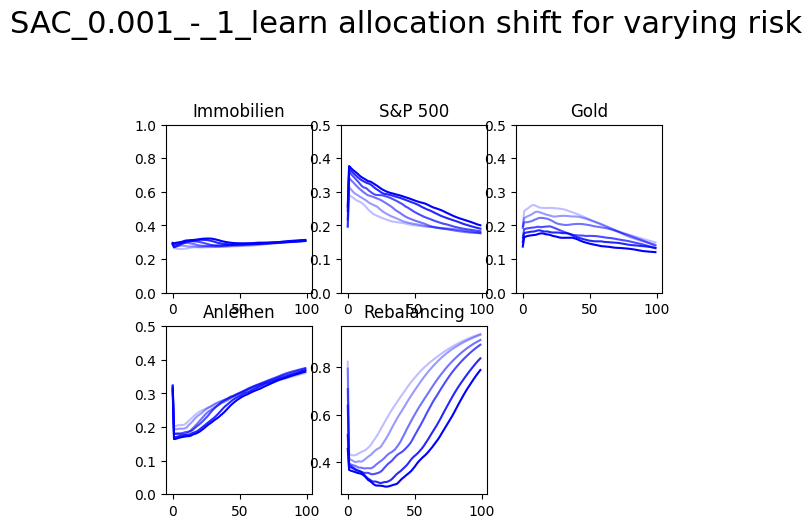

In [43]:
import matplotlib.pyplot as plt
# look at some predictions
 
        # aggregated_timeseries = 1 + (action[0] / action.sum())*(relevant_timeseries["S&P 500 (includes dividends)"].values.cumprod()-1) \
        # +((action[1] / action.sum())*(relevant_timeseries["gold"].values.cumprod()-1)) \
        #   + ((action[2] / action.sum())*(relevant_timeseries["Real Estate"].values.cumprod()-1)) \
        #     + ((action[3] / action.sum())*(relevant_timeseries["US T. Bond"].values.cumprod()-1))
scores_risk = []
risk_actions_sp500 = []
risk_actions_gold = []
risk_actions_real_estate = []
risk_actions_bonds = []
risk_actions_reb = []
mdls = ['A2C_0.0001_False_5','SAC_0.001_-_1_learn',"SAC_0.01_-_30"]
mdl=mdls[1]
for pit in [11, 20, 30, 40, 50, 57] :
		#env.set_current_observation = i[1].values
		try:
			#print(env.current_observation)
			#print(i[1].values)
			risk_actions_sp500_inc = []
			risk_actions_gold_inc = []
			risk_actions_real_estate_inc = []
			risk_actions_bonds_inc = []
			risk_actions_reb_inc = []
			for risk_preference in range(0,100):
				env.current_point_in_time = pit
				env.risk_preference=risk_preference
				env.horizon_preference=7
				#action = models_1["PPO1_0.01_-_30"].predict(env.get_current_observation(20,risk_preference, 7), deterministic=True)
				#action = models_1["A2C_0.01_False_10"].predict(env.get_current_observation(20,risk_preference, 7), deterministic=True)
				action = models_1[mdl].predict(env.get_current_observation(env.current_point_in_time,risk_preference, 7), deterministic=True)
				#print("action is: {}, observation is {}".format(action))
				actions_sum = action[0][:4].sum()
				#print(action[0][:4])
				#print("...")
				risk_actions_sp500_inc.append(action[0][0]/actions_sum)
				risk_actions_gold_inc.append(action[0][1]/actions_sum)
				risk_actions_real_estate_inc.append(action[0][2]/actions_sum)
				risk_actions_bonds_inc.append(action[0][3]/actions_sum)
				risk_actions_reb_inc.append(action[0][4])
				#scores_risk.append(env._calculate_reward(action[0]))
		
			risk_actions_sp500.append(risk_actions_sp500_inc)
			risk_actions_gold.append(risk_actions_gold_inc)
			risk_actions_real_estate.append(risk_actions_real_estate_inc)
			risk_actions_bonds.append(risk_actions_bonds_inc)
			risk_actions_reb.append(risk_actions_reb_inc)

		except Exception as e:
			print(e)
			scores_risk.append(0)

print(risk_actions_bonds)
fig = plt.figure()

ax1 = plt.subplot(2, 3, 1)
i = 0
for pit in [11, 20, 30, 40, 50, 57]:
	plt.plot(range(0,100), risk_actions_real_estate[i], color=(0,0,1, 0.25 + i * 0.15 ))
	i += 1
ax1.set_title("Immobilien")
ax1.set_ylim([0, 1])

ax2 = plt.subplot(2, 3, 2)
i = 0
for pit in [11, 20, 30, 40, 50, 57]:
	plt.plot(range(0,100), risk_actions_sp500[i], color=(0,0,1, 0.25 + i * 0.15 ))
	i += 1
ax2.set_title("S&P 500")
ax2.set_ylim([0, .5])

ax3 = plt.subplot(2, 3, 3)
i = 0
for pit in [11, 20, 30, 40, 50, 57]:
	plt.plot(range(0,100), risk_actions_gold[i], color=(0,0,1, 0.25 + i * 0.15 ))
	i += 1
ax3.set_title("Gold")
ax3.set_ylim([0, .5])

ax4 = plt.subplot(2, 3, 4)
i = 0
for pit in [11, 20, 30, 40, 50, 57]:
	plt.plot(range(0,100), risk_actions_bonds[i], color=(0,0,1, 0.25 + i * 0.15 ))
	i += 1
ax4.set_title("Anleihen")
ax4.set_ylim([0, .5])
ax5 = plt.subplot(2, 3, 5)
i = 0
for pit in [11, 20, 30, 40, 50, 57]:
	plt.plot(range(0,100), risk_actions_reb[i], color=(0,0,1, 0.25 + i * 0.15 ))
	i += 1
ax5.set_title("Rebalancing")
#ax5.set_ylim([0, .5])

fig.suptitle('{} allocation shift for varying risk'.format(mdl), fontsize=22, y=1.12)
plt.savefig('{}_scatter_risk_dep_allocs.pdf'.format(mdl), bbox_inches='tight' )
plt.show()		

In [ ]:

# plot top average strategies
print(scores)
plt.rcParams["figure.figsize"] = (20,30)
labels = ['S&P 500', 'Gold', 'Real Estate', "Gov. Bonds"]
sorted_by_reward = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1])}
fig, axs = plt.subplots(4)
k = 0
m = 0
l=0
for mdl in list(['A2C_1e-05_False_10', 'PPO1_1e-05_-_30', 'DDPG_1e-05_-_1', 'SAC_0.01_-_1', ]):#list(sorted_by_reward.keys())[-3:]:
        #print("Plotting {}".format(mdl))
        axs[m].pie(average_actions[mdl],
                shadow=True, startangle=90, colors=["red", "orange", "blue", "green"])
        lbls = [f'{l}, {(s / average_actions[mdl].sum() * 100):0.1f}%' for l, s in zip(labels, average_actions[mdl])]
        axs[m].legend(lbls, loc='upper left',
           fontsize=10)
        axs[m].title.set_text(mdl)
        m+=1
       
        #print(l)
#plt.legend()

In [ ]:
scores = {}
average_actions = {}
revenues = {}
actions = {}
total_score = 0
#models = [A2C, PPO, DDPG, SAC, TD3]
learning_rates = [0.001, 0.00001, 0.0000001]
batch_sizes = [1, 10, 30]
total_timesteps = 10000

# for learning_rate, batch_size, use_rms_prop in product(learning_rates, batch_sizes, [True, False]):
# 	m = A2C('MlpPolicy',env,learning_rate = learning_rate, n_steps=batch_size, use_rms_prop = use_rms_prop, seed=1)
# 	m.learn(total_timesteps=total_timesteps, callback=eval_callback)
# 	key = "{}_{}_{}_{}".format("A2C",str(learning_rate), str(use_rms_prop), str(batch_size))
# 	scores[key], average_actions[key], revenues[key], actions[key] = calculate_score_on_val(m)

# for learning_rate in learning_rates:
# 	for batch_size in batch_sizes:
	
stop_train_callback =  StopTrainingOnNoModelImprovement(max_no_improvement_evals=3, min_evals=5, verbose=1)
eval_callback = EvalCallback(eval_env, eval_freq=500, callback_after_eval=stop_train_callback, verbose=1)
n_actions = env.action_space.shape[-1]
#action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.01 * np.ones(n_actions))
m = SAC('MlpPolicy',env, learning_rate=0.00001, batch_size=3, seed=1)
m.learn(total_timesteps=total_timesteps, callback=eval_callback)
key = "{}_{}_-_{}".format("SAC",str(learning_rate), str(batch_size))
scores[key], average_actions[key], revenues[key], actions[key] = calculate_score_on_val(m)

scores

In [ ]:
import os.path
import sys
from os import system

import gym
import torch
#import torchsummary
import tensorflow as tf
import onnx
from onnx_tf.backend import prepare


class OnnxablePolicy(torch.nn.Module):
  def __init__(self,  actor):
      super(OnnxablePolicy, self).__init__()
      self.actor = torch.nn.Sequential(actor.latent_pi, actor.mu)

  def forward(self, observation):
      # NOTE: You may have to process (normalize) observation in the correct
      #       way before using this. See `common.preprocessing.preprocess_obs`
      return self.actor(observation)

print('Exporting to ONNX...')
onnxable_model = OnnxablePolicy(m.policy.actor)
m.policy.to("cpu")
m.policy.eval()
print(str(onnxable_model.actor))
# torchsummary.summary(model.policy.actor, input_size=len(dummy_input))
obs = env.observation_space
dummy_input = torch.FloatTensor(obs.sample().reshape(1, -1))

torch.onnx.export(onnxable_model, dummy_input, "mdl.onnx",
                    input_names=['input'],
                    output_names=['output'],
                    opset_version=9, verbose=True)

# print('Loading ONNX and checking...')
# onnx_model = onnx.load("mdl.onnx")
# onnx.checker.check_model(onnx_model)
# print(onnx.helper.printable_graph(onnx_model.graph))

# print('Converting ONNX to TF...')
# tf_rep = prepare(onnx_model)
# tf_rep.export_graph("mdl")

# print('Converting TF to TFLite...')
# converter = tf.lite.TFLiteConverter.from_saved_model("mdl")
# tflite_model = converter.convert()
# with open("mdl.tflite", 'wb') as f:
#     f.write(tflite_model)

In [ ]:
print(val_data.head(1))
# run through observations and calculate rewards...

obs = env.get_current_observation()
res = model.predict(obs)[0]

print(obs)
print(res)



# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['S&P 500', 'Gold', 'Real Estate', "Gov. Bonds"]
sizes = res
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
df = pd.DataFrame({"time":list(range(0,10)),"S&P":obs[0:10].cumprod(), "Gold":obs[10:20].cumprod(), "Real Estate":obs[20:30].cumprod(), "Gov. Bonds":obs[30:40].cumprod()})
df.plot("time", ["S&P", "Gold", "Real Estate", "Gov. Bonds"])

plt.show()
plt.bar(["risk in %", "investment horizon in yrs."], [obs[-2], obs[-1]], )
plt.ylim([0,100])

In [ ]:
print(total_score)

In [ ]:
#obs = env.get_current_observation()
res = model.predict(obs, deterministic=True)[0]

print(obs)
print(res)

In [ ]:


import yfinance as yf

# Lange Aktienhistorie -> GDP Zeitreihen, abweichung etwa 2.3% ?

acwi = yf.Ticker("SPY")

# get stock info
acwi.history(period="max")

In [ ]:
#Gold since 2000
acwi = yf.Ticker("GC%3DF")

# get stock info
acwi.history(period="max")

In [ ]:
import pandas as pd
import numpy as np
import os
# raw_data = pd.read_csv(os.path.join(os.getcwd(),"../data/flat_table1.csv"), sep="|")
# raw_vintage_data = pd.read_csv(os.path.join(os.getcwd(),"../data/all_vintages1.csv"), sep="|")
# del raw_data["Unnamed: 0"]
# del raw_vintage_data["Unnamed: 0"]

In [ ]:

target_columns_and_group_by = ['preferences_wineloverVsInvestor', 'preferences_takesRisk',
    'preferences_investmentHorizon', 'vintage_id', 'preferences_user_email',]

raw_data = raw_data[raw_data["preferences_email"].isin(["thomas@test.de", "patrick@test.de", "tradi@test.de", "angsthase@test.de", "zocker@test.de", "heinreich@test.de", "weinliebhaber@test.de", "investor@test.de", "kurz@test.de", "lang@test.de"])]
data = raw_data[target_columns_and_group_by].groupby(["vintage_id"]).mean()
vintage_features = raw_vintage_data#.set_index("id")
vintage_features_columns = []
for x in [l for l in vintage_features.columns if "statistics_climate" not in l and "breakdown" not in l]:
    #print(x)
    vintage_features_columns.append(x)
vintage_features_columns.remove("gwsRecord")
vintage_features_columns.remove("wine_winery_subregion")
vintage_features_columns.remove("wine_winery_subregion_id")
vintage_features_columns.remove("wine_winery_region_id")
vintage_features_columns.remove("wine_winery_classification_id")
vintage_features_columns.remove("wine_winery_title")
vintage_features_columns.remove("wine_winery_id")
vintage_features_columns.remove("title")
vintage_features_columns.remove("wine_winery_classification")
vintage_features_columns


vintage_features = raw_data.drop_duplicates()



#vintage_data = raw_vintage_data[feature_column_selection_vintages]
vintage_data = raw_vintage_data[vintage_features_columns]


delete = ["preferences_wineloverVsInvestor", "preferences_takesRisk", "preferences_investmentHorizon" , "preferences_user_email"]
for d in delete:
    try:
        del vintage_features[d]
    except Exception as e:
        print(e)

raw_data.shape



In [ ]:



new_data = pd.merge(vintage_data.set_index("id"), data, how="left", left_index=True, right_index=True)



In [ ]:


shorter_titles = {
'latestSellPrice750': "price_750",
 'id':"id",
 'lwin11':"lwin11",
 'year':"year",
 "bottleSize_factorForLiterPrices": "bottle",
 'wine_winery_region_titleUnidecoded':"region",
 'wine_winery_region_country_title':"country",
 'wine_winery_production': "production_p_a",
 'wine_winery_location': "location",
 'wine_winery_classification_titleUnidecoded':"clfkt",
 'statistics_appelation_in_top_percentage_value':"in_top_x_perc_of_app",
 'wine_winery_subregion_titleUnidecoded':"subregion",
 'gwsRecord_livexSubindex':"livex_subindex",
 'gwsRecord_livexSubsubindex':"livex_subsubindex",
 'gwsRecord_isLivex1000':"livex1000",
 'gwsRecord_score':"gws",
 'gwsRecord_journalistCount':"journalist_count",
 'gwsRecord_confidenceIndex':"confidence_index"
}

for k in shorter_titles:
    if not k == shorter_titles[k]:
        try:
            new_data[shorter_titles[k]] = new_data[k]
          
            
            del new_data[k]
         
        except: 
            pass
   





In [ ]:
# CLEAN FEATURES
import numpy as np
from datetime import datetime

try:
    del new_data["statistics_appelation_in_top_percentage_appellation"]
except Exception as e:
    print(e)

new_data["gws"] = new_data["gws"].fillna(new_data["gws"].mean())
new_data["in_top_x_perc_of_app"] = new_data["in_top_x_perc_of_app"].fillna(new_data["in_top_x_perc_of_app"].mean())
new_data["price_750"] = new_data["price_750"].fillna(new_data["price_750"].median())
new_data["drinkingMaturityFrom"] = new_data["drinkingMaturityFrom"].fillna(new_data["drinkingMaturityFrom"].median())
new_data["price_per_point"] = new_data["gws"] / new_data["price_750"]
new_data["journalist_count"] = new_data["journalist_count"].fillna(new_data["journalist_count"].median()).astype("float", copy=False)


try:
    new_data["lat"] = new_data["location"].apply(lambda x: x.split("(")[1].split(")")[0].split(" ")[0]).astype("float", copy=False)
    new_data["long"] = new_data["location"].apply(lambda x: x.split("(")[1].split(")")[0].split(" ")[1]).astype("float", copy=False)

    del new_data["location"]
except Exception as e:
    print(e)

dirtfree_data = new_data

dirtfree_data.replace(to_replace=["None"], value=np.nan, inplace=True)

dirtfree_data["year"] = (datetime.now().year) - dirtfree_data["year"]
dirtfree_data["drinkingMaturityFrom"] = (datetime.now().year) - dirtfree_data["drinkingMaturityFrom"]



cat_cols = ["country", "region", "subregion", "clfkt", "livex1000", "livex_subindex", "livex_subsubindex"]

for col in cat_cols:
    dirtfree_data[col] = dirtfree_data[col].astype("category", copy=False)

print(dirtfree_data.head(10))
dirtfree_data.shape


In [ ]:

dummyfied_data = pd.get_dummies(dirtfree_data, dummy_na=True, drop_first=True)

try:
    dummyfied_data.set_index(dummyfied_data["lwin11"], inplace=True, drop=True)
    del dummyfied_data["lwin11"]
    del dummyfied_data["vintage"]
except Exception:
    print("Index already set to lwin11")



dummyfied_data.head(15)

In [ ]:
# Split labels and features
from sklearn.preprocessing import StandardScaler

X = dummyfied_data

try:
    del X["preferences_user_email"]
except:
    pass



X_norm = X.select_dtypes('float')
X_norm_np = StandardScaler().fit_transform(X_norm)
print(X_norm_np)


try:
  del X["offer_vintage_id_norm"]
except:
  pass

try:
  del X["id_norm"]
except:
  pass






In [ ]:




#print(X_norm_only.columns)

try:
  X_unlabled = X_norm_only.copy()#[X_norm_only["preferences_takesRisk"].isnull()]
  for c in ["preferences_takesRisk", "preferences_wineloverVsInvestor", "preferences_investmentHorizon"]:
    del X_unlabled[c]
  X_norm_only = X_norm_only[~X_norm_only["preferences_takesRisk"].isnull()]
 
except Exception as e:
  print(e)

X_norm_only.shape
X_unlabled.shape


In [ ]:
X_norm_only = X


import seaborn as sns
import matplotlib.pyplot as plt

numerical_features = [
    "year",
    "drinkingMaturityFrom",
    "alc",
    "price_750",
    "production_p_a",
    "in_top_x_perc_of_app",
    "price_per_point",
    "gws",
    "lat",
    "long",
    "journalist_count"
]

target = 'preferences_takesRisk'

plot_data_labels_to_delete = ['preferences_investmentHorizon', 'preferences_takesRisk', 'preferences_wineloverVsInvestor']
plot_data_labels_to_delete.remove(target)


plt.figure(figsize=(4, 28))
heatmap = sns.heatmap(X_norm_only[X_norm_only.columns.difference(plot_data_labels_to_delete)].corr(method="spearman")[[target]].sort_values(by=target, key=abs, ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title("Spearman Feature Correlations with {}".format(target), fontdict={'fontsize':18}, pad=16)
plt.savefig('{}_spearman_feature_label_correlation1.pdf'.format(target), bbox_inches='tight')

In [ ]:
plt.figure(figsize=(20, 12))
tgt = ['gws', "alc", 'price_750', "in_top_x_perc_of_app", "production_p_a", "year", "price_per_point", "lat"]
ind = 2
regplot = sns.regplot(data=X_norm_only, x=tgt[ind], y=target)
regplot.set_title("Relation between {} and the label {}".format(tgt[ind], target), fontdict={'fontsize':18}, pad=16)
plt.savefig('{}_{}_scatterplot1.pdf'.format(tgt[ind], target), bbox_inches='tight')
print(X_norm_only.shape)


In [ ]:


try:
  #X_unlabled = X_norm_only[X_norm_only["preferences_takesRisk"].isnull()]
  #X_norm_only = X_norm_only[~X_norm_only["preferences_takesRisk"].isnull()]
  #del X_norm_only['preferences_wineloverVsInvestor']
  del X_norm_only['preferences_wineloverVsInvestor_norm']
  #del X_norm_only['preferences_takesRisk']
  del X_norm_only['preferences_takesRisk_norm']
  #del X_norm_only['preferences_investmentHorizon']
  del X_norm_only['preferences_investmentHorizon_norm']
except Exception as e:
  print(e)

try:
  #X_unlabled = X_norm_only[X_norm_only["preferences_takesRisk"].isnull()]
  #X_norm_only = X_norm_only[~X_norm_only["preferences_takesRisk"].isnull()]
  #del X_norm_only['preferences_wineloverVsInvestor']
  del X_unlabled['preferences_wineloverVsInvestor_norm']
  #del X_norm_only['preferences_takesRisk']
  del X_unlabled['preferences_takesRisk_norm']
  #del X_norm_only['preferences_investmentHorizon']
  del X_unlabled['preferences_investmentHorizon_norm']
except Exception as e:
  print(e)









try: 
  y_wvi = X_norm_only['preferences_wineloverVsInvestor']
  y_tr = X_norm_only['preferences_takesRisk']
  y_ih = X_norm_only['preferences_investmentHorizon']
  del X_norm_only['preferences_wineloverVsInvestor']
  del X_norm_only['preferences_takesRisk']
  del X_norm_only['preferences_investmentHorizon']
except Exception as e:
  print(e)

    
except:
    pass


#sns.heatmap(X_norm_only.corr())


plt.figure(figsize=(15, 10))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(X_norm_only[numerical_features].corr(), dtype=np.bool))
heatmap = sns.heatmap(X_norm_only[numerical_features].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("coolwarm_r", as_cmap=True))
#heatmap.set_title('Triangle absolute correlation heatmap of features', fontdict={'fontsize':23}, pad=20)
X_norm_only.columns
print(X_norm_only.shape)
plt.savefig('numberical_correlations_features.pdf', bbox_inches='tight')



In [ ]:

categorical_features = [ x for x in X_norm_only.columns if x not in numerical_features]

corr = X_norm_only[categorical_features].corr(method="spearman")


plt.figure(figsize=(26,26))
corr = corr.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
cut_off = 0  # only show cells with abs(correlation) at least this value
extreme_1 = 0.75  # show with a star
extreme_2 = 0.85  # show with a second star
extreme_3 = 0.90  # show with a third star
mask |= np.abs(corr) < cut_off
corr = corr[~mask]  # fill in NaN in the non-desired cells

remove_empty_rows_and_cols = True
if remove_empty_rows_and_cols:
    wanted_cols = np.flatnonzero(np.count_nonzero(~mask, axis=1))
    wanted_rows = np.flatnonzero(np.count_nonzero(~mask, axis=0))
    corr = corr.iloc[wanted_cols, wanted_rows]

annot = [[f"{val:.4f}"
          + ('' if abs(val) < extreme_1 else '\n★')  # add one star if abs(val) >= extreme_1
          + ('' if abs(val) < extreme_2 else '★')  # add an extra star if abs(val) >= extreme_2
          + ('' if abs(val) < extreme_3 else '★')  # add yet an extra star if abs(val) >= extreme_3
          for val in row] for row in corr.to_numpy()]
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=annot, fmt='', cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize': 18}, pad=16)
plt.show()



# plt.figure(figsize=(15, 10))
# # define the mask to set the values in the upper triangle to True


# mask = np.triu(np.ones_like(X_norm_only[categorical_features].corr(method="spearman"), dtype=np.bool))
# heatmap = sns.heatmap(X_norm_only[categorical_features].corr(method="spearman"), mask=mask, vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("coolwarm_r", as_cmap=True))
# #heatmap.set_title('Triangle absolute correlation heatmap of features', fontdict={'fontsize':23}, pad=20)
# X_norm_only.columns
# print(X_norm_only.shape)
# plt.savefig('categorical_correlations_features.pdf', bbox_inches='tight
X_norm_only[numerical_features]

In [ ]:
for l in norm_labels_1:
  try:
  
    del X_norm_only[l]
  except:
    pass

for l in norm_labels_2:
  try:
  
    del X_norm_only[l]
  except:
    pass

for l in norm_labels_1:
  try:
  
    del X_unlabled[l]
  except:
    pass

for l in norm_labels_2:
  try:
  
    del X_unlabled[l]
  except:
    pass


In [ ]:
X_std = X_norm_only.copy()
X_std[numerical_features] = StandardScaler().fit_transform(X_norm_only[numerical_features])
print(X_std)




In [ ]:

# Train test split for WineloverVsInvestor label
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
#import neptune.new as neptune
import neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback
import neptunecontrib.monitoring.kerastuner as npt_utils 

# run = neptune.init(
#     project_qualified_name="martin.dammrath/BCRecSys",
#     api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2MWY3OWE1NS02ZDdhLTQ1ZmEtYTQxMS03NTNmNGIyYTQzNWIifQ==",
# )

# neptune.create_experiment('tuner-sweep')

# lreg = Ridge(alpha=1)
# tree = DecisionTreeRegressor(random_state=0)

# PREDICT RISK

from keras.losses import mean_squared_error

def root_mean_squared_error_loss(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.losses.MSE(y_true, y_pred))


def tune_model(y, npt_exp_str):
  # neptune.create_experiment(npt_exp_str)
  X_train, X_rem, y_train, y_rem = train_test_split(np.asarray(X_std).astype(np.float32), y, test_size=0.3, random_state=3)
  X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.4, random_state=3)
  print(y_train.shape, y_test.shape, y_valid.shape)
  def build_model(hp):
    learning_rate = hp.Float("lr", min_value=1e-3, max_value=1e-1, sampling="log")
    #batch_size = hp.Int("bs",  min_value=2, max_value=10, step=1)
    model = keras.Sequential()
    model.add(keras.layers.Dense(72, activation='relu'))
    for i in range(hp.Int("n_layers", 1, 6)):
      model.add(keras.layers.Dense(
      units = hp.Int(f"units_{i}", min_value=5, max_value=120, step=5),
      activation=hp.Choice(f"act_{i}", ["relu", "tanh"])))
      if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=(hp.Float(f"do_{i}", min_value = 0.2, max_value = 0.8, step=0.2))))
    model.add(keras.layers.Dense(1, activation='relu'))
    model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate),  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.fit(X_train,y_train, epochs=1)
    return model

  # Root mean squared error
  


  # Better try different ones here like Bayesian Optimization
  tuner = kt.RandomSearch(
      hypermodel=build_model,
      objective='val_loss',
      max_trials=10,
      executions_per_trial=2,
      overwrite=True,
      seed=5,
      project_name='tuner-sweep',
      directory="./"
      )

  tuner.search_space_summary()

  tuner.search(x=X_train,
              y=y_train,
              epochs=200,
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100), ],
              batch_size=5,
              validation_data=(X_valid, y_valid),
              verbose=True)

  # npt_utils.log_tuner_info(tuner)

  tuner.results_summary()

  # neptune.stop()

  models = tuner.get_best_models(num_models=2)
  best_model = models[0]
  best_model.build(input_shape=X_train.shape)
  print(best_model.summary())

  return best_model

fnn_tr = tune_model(y_tr, "takes_risk_tuning")
fnn_ih = tune_model(y_ih, "invest_horizon_tuning")
fnn_wvi = tune_model(y_wvi, "winelover_vs_invest_tuning")

#run.stop()


In [ ]:

from sklearn.metrics import mean_squared_error
from math import sqrt

def calculate_rmse_for_model(fnn, y):
    X_train, X_rem, y_train, y_rem = train_test_split(np.asarray(X_std).astype(np.float32), y, test_size=0.2, random_state=3)
    X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, random_state=3)
    
    print(fnn.summary())
    K = tf.keras.backend

    def root_mean_squared_error(y_true, y_pred):
            return sqrt(mean_squared_error(list(y_pred),list(y_true)))
    print("rmse val: ", root_mean_squared_error(y_valid.values,fnn.predict(X_valid)))
    print("rmse test: ", root_mean_squared_error(y_test.values,fnn.predict(X_test)))
            
    return 0

print("----- TAKES RISK -----")
calculate_rmse_for_model(fnn_tr, y_tr)

print("----- INVESTMENT HORIZON -----")
calculate_rmse_for_model(fnn_ih, y_ih)
print("----- WVI -----")
calculate_rmse_for_model(fnn_wvi, y_wvi)

In [ ]:
X_norm_only


In [ ]:


#print(lreg.predict(X_train), y_train)
# for x in zip(lreg.coef_,X_train.columns):
#     print("{}: {}".format(x[1], x[0]))

# DALEX
# BREAK DOWN

import dalex as dx
X_transf = np.asarray(X_std).astype(np.float32)
#surrogate = dx.Explainer.model_surrogate()
exp_tr = dx.Explainer(fnn_tr, X_std, y_tr, label="y_tr")
exp_wvi = dx.Explainer(fnn_wvi, X_std, y_tr, label="y_wvi")
exp_ih = dx.Explainer(fnn_ih, X_std, y_tr, label="y_ih")
#exp.predict(X_transf)[0:10]
#X[:1]

observation_no = 12
sample = X_transf[observation_no - 1:observation_no]
#print(X_norm_only[observation_no - 1:observation_no].index)



In [ ]:


bd = exp_ih.predict_parts(X_std[7:8], type='break_down', label="Exp")


labels = []

for x in bd.result.variable_name:
    try:
        labels.append(X_norm_only.columns[int(x)])
    except:
        labels.append(x)
        
bd.result.variable_name=labels
#bd.result.variable_name = labels
#bd.result.set_index(bd.result.variable_name, inplace=True)
res = pd.concat([bd.result[1:5], bd.result[-5:]])
#exp.model_parts().plot()
print(bd.result)

res
bd.plot(max_vars=72)





In [ ]:
import random
fig, ax = plt.subplots(figsize=(15,25)) 

zpd = sorted(zip(bd.result.contribution[1:-1], labels[1:-1]))
plt.barh([x for _,x in (zpd)], [x for x,_ in (zpd)], align='center', alpha=0.5)
#plt.bar_label( [x for x,_ in (zpd)])

for i, v in enumerate( [round(x,2) for x,_ in (zpd)]):     
    if v > 0:
        z = -0.5
    else:
        z = 0.25
    ax.text(z, i - 0.15 , str(v), color='grey', fontweight='bold')


#plt.savefig('contribution_{}_tr.pdf'.format(str(random.randint(0, 1000))), bbox_inches='tight')






In [ ]:
from keras.utils.vis_utils import plot_model
#plot_model(fnn_tr, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
fnn_wvi.summary()
for i, layer in enumerate (fnn_wvi.layers):
    print (i, layer)
    try:
        print ("    ",layer.activation)
    except AttributeError:
        print('   no activation attribute')

In [ ]:
pred_tr = fnn_tr.predict(X_unlabled)
pred_wvi = fnn_wvi.predict(X_unlabled)
pred_ih = fnn_ih.predict(X_unlabled)

X_unlabled_transf = np.asarray(X_unlabled).astype(np.float32)

expl_tr = []
expl_wvi = []
expl_ih = []

for sample in X_unlabled_transf:
    expl = exp_tr.predict_parts(sample, type='break_down', label="bd")
    expl.result.variable_name = labels
    expl = pd.concat([expl.result[1:3], expl.result[-3:-1]])
    expl = expl.transpose().to_dict()
    expl_tr.append([expl[k] for k in expl.keys()])

    expl = exp_wvi.predict_parts(sample, type='break_down', label="bd")
    expl.result.variable_name = labels
    expl = pd.concat([expl.result[1:3], expl.result[-3:-1]])
    expl = expl.transpose().to_dict()
    expl_wvi.append([expl[k] for k in expl.keys()])

    expl = exp_ih.predict_parts(sample, type='break_down', label="bd")
    expl.result.variable_name = labels
    expl = pd.concat([expl.result[1:3], expl.result[-3:-1]])
    expl = expl.transpose().to_dict()
    expl_ih.append([expl[k] for k in expl.keys()])

tp = res.transpose().to_dict()
r = [tp[k] for k in tp.keys()]


In [ ]:
mdl = fnn_wvi
print(mdl.summary())
for i, layer in enumerate (mdl.layers):
    print (i, layer)
    try:
        print ("    ",layer.activation)
    except AttributeError:
        print('   no activation attribute')

In [ ]:
result_json = []
for s in list(zip(pred_tr, expl_tr, pred_wvi, expl_wvi, pred_ih, expl_ih)):
    result_json.append(
        {
        "takes_risk_prediction": s[0][0],
        "takes_risk_breakdown": s[1],
        "winelover_vs_investor_prediction": s[2][0],
        "winelover_vs_investor_breakdown": s[3],
        "investment_horizon_prediction": s[4][0],
        "investment_horizon_breakdown": s[5],
        }
    )

result_json[0]

In [ ]:
import json
lwins = X_unlabled.index.values
i = 0
for sample in result_json:
    sample["lwin_11"] = str(lwins[i])
    sample["takes_risk_prediction"] = float(sample["takes_risk_prediction"])
    sample["winelover_vs_investor_prediction"] = float(sample["winelover_vs_investor_prediction"])
    sample["investment_horizon_prediction"] = float(sample["investment_horizon_prediction"])
    i += 1
    print(i)
#json_string = json.dumps(result_json)
with open('model_results.json', 'w') as outfile:
    json.dump(result_json, outfile)

In [ ]:
type(result_json[0]['takes_risk_prediction'])

In [ ]:

f = open("model_results.json")
im = json.load(f)
im

In [ ]:
print(result_json)
X_unlabled.shape
